# TESS Atlas fit for TOI 191

**Version: 0.1.0**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 191.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-191.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-191.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.0/toi-191.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 191

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 191 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

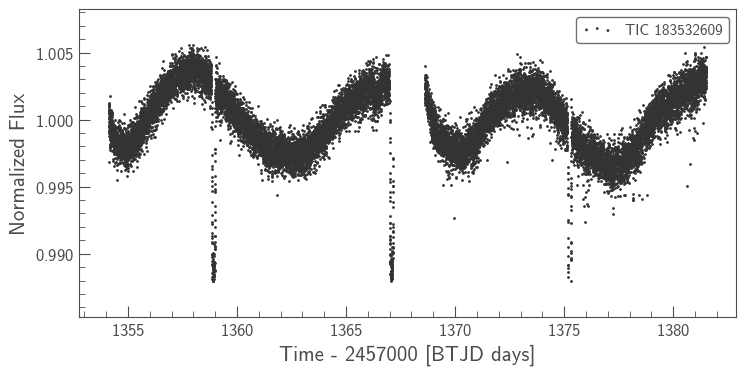

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")

# tpf_collection[0].to_lightcurve(aperture_mask="pipeline").plot()
# assert 0
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])    
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
lc = lc.remove_outliers()
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] *= 1000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -28264.056156076957 -> -26241.226436902143


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -24772.136182442788 -> -24710.62229179044


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -24710.622291790438 -> -22574.276352189787


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -22574.276352189787 -> -22313.462170126873


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -22313.462170126873 -> -22310.148397143617


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -22310.148397143617 -> -22282.795598484365


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -22282.795598484365 -> -21847.358359692545


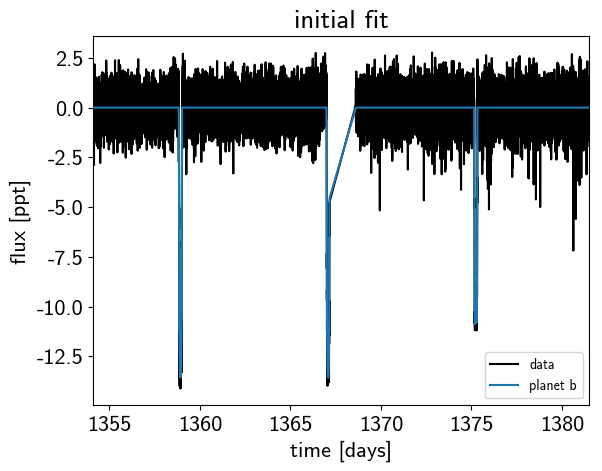

In [7]:
model = build_model(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:04, 21.01draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:00<00:09,  9.76draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:12,  7.05draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:01<00:14,  5.91draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:02<00:16,  5.31draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:02<00:17,  4.85draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:03<00:17,  4.66draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:03<00:17,  4.48draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:04<00:17,  4.40draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:04<00:17,  4.35draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:05<00:17,  4.27draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:05<00:13,  5.15draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:05<00:17,  4.06draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:05<00:14,  4.79draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:06<00:17,  4.02draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:06<00:14,  4.70draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:06<00:16,  3.97draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:06<00:14,  4.67draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:07<00:16,  3.97draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:07<00:14,  4.41draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:07<00:15,  4.01draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:07<00:14,  4.42draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:08<00:15,  3.91draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:08<00:13,  4.49draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:08<00:15,  3.78draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:08<00:13,  4.33draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:09<00:14,  3.82draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:09<00:12,  4.50draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:09<00:14,  3.92draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:09<00:11,  4.60draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:10<00:14,  3.75draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:10<00:11,  4.57draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:10<00:13,  3.85draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:10<00:10,  4.61draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:11<00:12,  3.88draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:11<00:10,  4.38draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:11<00:12,  3.87draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:11<00:10,  4.43draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:12<00:12,  3.53draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:12<00:11,  3.61draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:13<00:11,  3.71draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:13<00:10,  3.74draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:14<00:10,  3.63draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:14<00:09,  3.74draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:15<00:08,  3.86draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:15<00:07,  3.90draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:15<00:06,  4.58draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:16<00:07,  3.80draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:16<00:06,  4.12draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:16<00:06,  3.91draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:16<00:06,  3.80draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:17<00:05,  4.60draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:17<00:05,  3.97draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:17<00:05,  4.21draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:17<00:05,  4.00draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:18<00:05,  3.95draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:18<00:04,  3.98draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:18<00:04,  3.78draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:19<00:04,  3.90draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:19<00:04,  3.97draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:19<00:03,  3.95draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:19<00:03,  3.93draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:20<00:03,  3.95draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:20<00:03,  3.91draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:20<00:02,  4.04draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:20<00:02,  3.81draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:21<00:02,  4.03draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:21<00:02,  3.77draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:21<00:01,  4.02draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:21<00:01,  3.80draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:22<00:01,  4.25draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:22<00:01,  3.92draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:22<00:00,  4.44draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:22<00:00,  3.99draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:24<00:00,  1.58draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:24<00:00,  1.83draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:04, 21.00draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:09,  9.34draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:13,  6.64draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:15,  5.44draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:02<00:17,  4.87draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:18,  4.43draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:03<00:20,  4.00draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:04<00:18,  4.32draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:04<00:18,  4.19draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:05<00:18,  4.06draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:05<00:14,  4.98draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:05<00:16,  4.24draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:06<00:17,  4.07draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:06<00:17,  4.02draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:06<00:16,  4.00draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:06<00:16,  4.02draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:07<00:16,  4.07draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:07<00:16,  3.90draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:07<00:16,  3.86draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:07<00:17,  3.68draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:08<00:16,  3.67draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:08<00:16,  3.79draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:08<00:17,  3.45draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:09<00:15,  3.81draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:09<00:16,  3.42draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:09<00:14,  3.99draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:09<00:17,  3.16draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:10<00:14,  3.66draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:11<00:13,  3.72draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:11<00:12,  3.80draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:11<00:09,  4.87draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:12<00:11,  3.86draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:12<00:09,  4.66draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:12<00:09,  4.72draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:12<00:07,  5.30draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:13<00:10,  3.95draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:13<00:08,  4.56draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:13<00:10,  3.86draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:13<00:08,  4.44draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:14<00:09,  3.80draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:14<00:08,  4.24draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:14<00:09,  3.80draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:14<00:08,  4.21draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:15<00:09,  3.65draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:15<00:07,  4.27draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:15<00:08,  3.58draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:15<00:07,  4.19draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:16<00:08,  3.47draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:16<00:07,  3.83draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:16<00:07,  3.74draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:16<00:07,  3.58draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:17<00:06,  4.02draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:17<00:06,  3.82draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:17<00:04,  4.73draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:17<00:05,  4.13draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:18<00:04,  4.59draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:18<00:05,  3.28draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:19<00:04,  3.41draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:19<00:03,  3.84draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:20<00:03,  3.70draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:20<00:02,  3.77draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:20<00:01,  4.90draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:21<00:01,  3.82draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:21<00:01,  4.27draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:21<00:00,  4.70draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:22<00:01,  2.75draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:23<00:00,  2.38draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:23<00:00,  2.35draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:25<00:00,  1.31draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:45,  1.92draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<01:18,  2.57draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:10,  2.81draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<00:54,  3.59draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:01<00:53,  3.69draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:01<00:45,  4.32draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:02<00:51,  3.76draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:02<00:43,  4.46draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:02<00:35,  5.40draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:02<00:31,  6.01draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:02<00:31,  6.03draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:03<00:33,  5.56draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:03<00:34,  5.46draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:03<00:27,  6.56draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:03<00:40,  4.47draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:04<00:37,  4.78draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:04<00:41,  4.31draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:04<00:36,  4.90draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:04<00:28,  6.18draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:04<00:26,  6.59draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:04<00:25,  6.77draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:05<00:34,  5.02draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:05<00:39,  4.39draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:05<00:40,  4.30draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:05<00:30,  5.60draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:06<00:29,  5.71draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:06<00:38,  4.37draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:06<00:34,  4.84draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:06<00:30,  5.45draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:07<00:43,  3.73draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:07<00:32,  4.97draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:07<00:32,  4.86draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:08<00:27,  5.72draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:08<00:27,  5.63draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:08<00:20,  7.25draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:09<00:25,  5.89draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:09<00:30,  4.88draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:09<00:23,  6.18draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:09<00:26,  5.50draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:10<00:24,  5.86draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:10<00:42,  3.36draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:10<00:32,  4.37draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:11<00:33,  4.13draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:11<00:28,  4.80draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:11<00:23,  5.77draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:11<00:21,  6.28draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:11<00:19,  6.76draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:12<00:17,  7.37draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:12<00:29,  4.46draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:12<00:23,  5.45draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:13<00:30,  4.20draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:13<00:24,  5.07draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:13<00:34,  3.59draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:13<00:25,  4.75draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:13<00:25,  4.78draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:14<00:26,  4.55draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:14<00:22,  5.36draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:14<00:21,  5.53draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:15<00:27,  4.25draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:15<00:23,  4.84draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:15<00:25,  4.40draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:15<00:23,  4.79draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:16<00:17,  6.20draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:16<00:15,  6.97draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:16<00:21,  5.06draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:16<00:17,  6.04draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:16<00:22,  4.65draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:17<00:18,  5.53draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:17<00:22,  4.49draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:17<00:21,  4.79draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:17<00:15,  6.20draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:17<00:14,  6.85draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:18<00:11,  8.45draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:18<00:09,  9.51draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:18<00:13,  6.38draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:19<00:15,  5.58draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:19<00:15,  5.39draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:20<00:11,  6.85draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:20<00:15,  5.15draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:20<00:16,  4.85draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:21<00:14,  5.38draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:21<00:12,  5.99draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:21<00:10,  7.32draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:21<00:09,  7.56draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:21<00:08,  7.78draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:22<00:09,  6.93draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:22<00:10,  6.22draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:22<00:10,  6.39draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:23<00:12,  5.05draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:23<00:13,  4.75draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:23<00:11,  5.49draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:23<00:08,  6.97draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:24<00:11,  4.87draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:24<00:10,  5.26draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:25<00:07,  6.57draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:25<00:06,  7.36draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:25<00:05,  8.57draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:25<00:04,  9.40draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:25<00:04, 10.54draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:26<00:03, 11.22draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:26<00:03, 10.70draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:26<00:05,  6.94draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:26<00:04,  7.37draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:27<00:05,  5.99draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:27<00:04,  7.22draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:27<00:04,  6.34draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:27<00:04,  6.63draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:28<00:04,  5.85draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:28<00:04,  6.20draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:28<00:04,  5.29draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:29<00:04,  5.29draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:29<00:03,  5.78draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:29<00:02,  6.63draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:29<00:02,  7.21draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:29<00:02,  7.09draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:30<00:02,  5.92draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:30<00:03,  4.46draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:30<00:02,  4.44draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:30<00:02,  4.75draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:31<00:03,  3.46draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:31<00:03,  2.91draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:32<00:02,  3.23draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:32<00:02,  2.80draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:33<00:01,  3.12draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:33<00:01,  2.74draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:34<00:01,  2.54draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:34<00:01,  2.56draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:34<00:00,  3.24draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:34<00:00,  3.50draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:35<00:00,  2.72draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:11, 34.97draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:22, 17.59draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:00<00:29, 13.25draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:00<00:27, 14.14draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:00<00:31, 12.30draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:01<00:30, 12.74draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:01<00:28, 13.81draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:01<00:31, 12.06draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:01<00:28, 13.55draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:01<00:24, 15.80draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:01<00:21, 17.78draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:01<00:17, 21.27draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:01<00:16, 21.98draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:02<00:17, 20.68draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:02<00:15, 23.46draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:02<00:14, 24.10draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:02<00:15, 23.49draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:02<00:14, 23.96draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:02<00:18, 19.33draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:03<00:16, 20.98draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:03<00:15, 22.08draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:03<00:13, 24.51draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:03<00:12, 25.84draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:03<00:12, 25.56draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:03<00:13, 24.26draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:03<00:14, 22.62draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:03<00:14, 22.47draws/s]

Sampling 2 chains:  21%|██        | 84/404 [00:04<00:14, 22.27draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:04<00:14, 22.41draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:04<00:13, 24.07draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:04<00:13, 23.31draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:04<00:16, 18.14draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:04<00:17, 17.38draws/s]

Sampling 2 chains:  25%|██▌       | 101/404 [00:04<00:16, 17.90draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:05<00:15, 19.26draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:05<00:14, 21.16draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:05<00:12, 22.81draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:05<00:14, 19.93draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:05<00:13, 21.08draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:05<00:12, 21.88draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:05<00:11, 24.02draws/s]

Sampling 2 chains:  31%|███▏      | 127/404 [00:06<00:11, 23.81draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:06<00:10, 24.88draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:06<00:12, 22.18draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:06<00:11, 22.36draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:06<00:10, 24.79draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:06<00:11, 23.38draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:06<00:10, 23.24draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:07<00:10, 23.25draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:07<00:10, 22.89draws/s]

Sampling 2 chains:  39%|███▉      | 158/404 [00:07<00:11, 22.06draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:07<00:11, 20.95draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:07<00:11, 20.05draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:07<00:12, 18.62draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [00:08<00:13, 17.29draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:08<00:12, 18.95draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:08<00:12, 18.31draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:08<00:13, 16.56draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:08<00:13, 17.19draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:08<00:13, 16.45draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:08<00:13, 16.28draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:08<00:13, 16.02draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:09<00:12, 17.96draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:09<00:11, 18.81draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [00:09<00:10, 19.44draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:09<00:10, 20.41draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:09<00:10, 20.31draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:09<00:09, 20.57draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:09<00:09, 21.14draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:10<00:09, 20.60draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:10<00:10, 18.19draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:10<00:12, 14.73draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:10<00:12, 14.55draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:10<00:10, 17.12draws/s]

Sampling 2 chains:  54%|█████▍    | 220/404 [00:10<00:10, 17.88draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:10<00:09, 18.92draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:11<00:08, 19.90draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:11<00:08, 20.94draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:11<00:07, 22.38draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:11<00:07, 23.64draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:11<00:06, 26.75draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:11<00:06, 23.41draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:11<00:06, 23.17draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:11<00:06, 24.68draws/s]

Sampling 2 chains:  63%|██████▎   | 253/404 [00:12<00:05, 25.20draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:12<00:05, 27.21draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:12<00:05, 27.23draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:12<00:05, 25.70draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:12<00:05, 25.53draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [00:12<00:05, 23.37draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [00:13<00:07, 16.40draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:13<00:08, 15.05draws/s]

Sampling 2 chains:  69%|██████▉   | 279/404 [00:13<00:09, 13.64draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:13<00:08, 14.62draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [00:13<00:07, 15.48draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:13<00:07, 15.09draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:14<00:07, 14.89draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [00:14<00:07, 14.91draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:14<00:07, 15.00draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [00:14<00:06, 16.90draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:14<00:06, 16.97draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:14<00:06, 16.10draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:14<00:05, 17.34draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:15<00:05, 18.18draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:15<00:04, 20.18draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:15<00:03, 23.34draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:15<00:03, 22.60draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [00:15<00:03, 24.35draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:15<00:03, 24.64draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [00:15<00:03, 24.49draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:15<00:02, 25.44draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [00:16<00:03, 21.69draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:16<00:02, 23.12draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:16<00:02, 25.53draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:16<00:02, 25.23draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:16<00:02, 26.07draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:16<00:01, 27.55draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:17<00:01, 24.84draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:17<00:01, 23.46draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [00:17<00:01, 20.62draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [00:17<00:02, 18.87draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:17<00:01, 19.06draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:18<00:03, 10.57draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:18<00:03,  8.24draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [00:18<00:03,  8.11draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:18<00:03,  8.06draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [00:19<00:02,  8.55draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:19<00:02,  9.01draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [00:19<00:02,  9.45draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:19<00:02,  8.21draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:19<00:02,  7.81draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [00:20<00:02,  7.41draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:20<00:02,  7.13draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [00:20<00:02,  6.45draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:20<00:02,  6.19draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:20<00:02,  6.00draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [00:20<00:01,  7.39draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:21<00:01,  7.56draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:21<00:00,  8.32draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:21<00:00,  8.28draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:21<00:00,  8.26draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:21<00:00,  7.45draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:21<00:00,  6.52draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [00:22<00:00,  6.10draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:22<00:00,  5.92draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:22<00:00,  6.48draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:22<00:00, 18.00draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/804 [00:00<00:20, 38.98draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:20, 38.78draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<00:24, 32.80draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:00<00:23, 33.64draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:00<00:24, 31.96draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:00<00:21, 36.88draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:00<00:27, 28.55draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:01<00:30, 24.91draws/s]

Sampling 2 chains:   4%|▍         | 36/804 [00:01<00:30, 25.36draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:01<00:35, 21.32draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:01<00:41, 18.36draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:01<00:39, 19.33draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:01<00:38, 19.52draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:02<00:38, 19.78draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:02<00:37, 20.11draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:02<00:31, 23.73draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:02<00:27, 26.93draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:02<00:25, 29.05draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:02<00:23, 31.38draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:02<00:22, 31.86draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:02<00:21, 33.49draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:03<00:28, 25.68draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:03<00:28, 25.32draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:03<00:30, 23.77draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:03<00:31, 22.62draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:03<00:33, 21.31draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:03<00:33, 21.17draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:04<00:35, 19.63draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:04<00:30, 23.03draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:04<00:25, 27.27draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:04<00:23, 29.51draws/s]

Sampling 2 chains:  15%|█▍        | 120/804 [00:04<00:22, 29.75draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:04<00:21, 31.22draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:04<00:19, 34.43draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:04<00:17, 37.49draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:05<00:18, 35.82draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:05<00:24, 27.16draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:05<00:26, 24.36draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:05<00:25, 25.84draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:05<00:24, 26.06draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:05<00:26, 24.40draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:06<00:25, 25.45draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:06<00:25, 25.40draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:06<00:25, 25.13draws/s]

Sampling 2 chains:  22%|██▏       | 174/804 [00:06<00:24, 26.14draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:06<00:21, 29.07draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:06<00:18, 33.63draws/s]

Sampling 2 chains:  23%|██▎       | 188/804 [00:06<00:18, 33.16draws/s]

Sampling 2 chains:  24%|██▍       | 192/804 [00:06<00:18, 32.71draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [00:06<00:18, 33.72draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:07<00:17, 35.37draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:07<00:16, 36.17draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:07<00:20, 29.04draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:07<00:21, 27.98draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:07<00:21, 27.76draws/s]

Sampling 2 chains:  27%|██▋       | 221/804 [00:07<00:22, 26.44draws/s]

Sampling 2 chains:  28%|██▊       | 225/804 [00:08<00:22, 26.18draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:08<00:24, 23.42draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:08<00:21, 26.50draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [00:08<00:20, 28.13draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [00:08<00:19, 28.42draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:08<00:17, 31.79draws/s]

Sampling 2 chains:  31%|███       | 249/804 [00:08<00:16, 33.75draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [00:08<00:14, 38.21draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:09<00:14, 37.16draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:09<00:17, 30.23draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [00:09<00:24, 22.00draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [00:09<00:23, 22.28draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:09<00:23, 22.28draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:09<00:24, 21.91draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [00:10<00:22, 23.49draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:10<00:21, 24.06draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:10<00:21, 24.33draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:10<00:20, 25.34draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:10<00:18, 26.93draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [00:10<00:21, 23.11draws/s]

Sampling 2 chains:  37%|███▋      | 301/804 [00:10<00:20, 24.69draws/s]

Sampling 2 chains:  38%|███▊      | 306/804 [00:11<00:19, 25.45draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [00:11<00:17, 27.72draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [00:11<00:17, 28.79draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:11<00:16, 28.97draws/s]

Sampling 2 chains:  40%|████      | 322/804 [00:11<00:16, 29.81draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:11<00:17, 27.34draws/s]

Sampling 2 chains:  41%|████      | 330/804 [00:11<00:16, 29.01draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [00:11<00:15, 31.05draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [00:12<00:14, 32.76draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:12<00:12, 35.84draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [00:12<00:13, 33.29draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:12<00:13, 34.09draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:12<00:13, 32.33draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [00:12<00:14, 30.50draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [00:12<00:14, 29.40draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [00:13<00:15, 28.65draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [00:13<00:16, 26.76draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:13<00:16, 26.07draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [00:13<00:16, 25.81draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:13<00:16, 25.31draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [00:13<00:17, 24.54draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:13<00:19, 21.46draws/s]

Sampling 2 chains:  49%|████▉     | 392/804 [00:13<00:16, 24.85draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [00:14<00:14, 28.96draws/s]

Sampling 2 chains:  50%|████▉     | 401/804 [00:14<00:13, 29.30draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:14<00:13, 30.11draws/s]

Sampling 2 chains:  51%|█████     | 409/804 [00:14<00:13, 29.58draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [00:14<00:12, 30.43draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [00:14<00:12, 31.13draws/s]

Sampling 2 chains:  52%|█████▏    | 421/804 [00:14<00:11, 32.46draws/s]

Sampling 2 chains:  53%|█████▎    | 425/804 [00:14<00:11, 32.95draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:15<00:10, 34.71draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [00:15<00:11, 32.58draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:15<00:14, 25.19draws/s]

Sampling 2 chains:  55%|█████▍    | 440/804 [00:15<00:15, 23.12draws/s]

Sampling 2 chains:  55%|█████▌    | 444/804 [00:15<00:14, 24.17draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [00:15<00:14, 25.39draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:15<00:13, 26.67draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [00:16<00:12, 28.29draws/s]

Sampling 2 chains:  57%|█████▋    | 460/804 [00:16<00:11, 30.75draws/s]

Sampling 2 chains:  58%|█████▊    | 465/804 [00:16<00:10, 33.63draws/s]

Sampling 2 chains:  58%|█████▊    | 470/804 [00:16<00:09, 34.61draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [00:16<00:08, 38.36draws/s]

Sampling 2 chains:  60%|█████▉    | 481/804 [00:16<00:08, 38.69draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [00:16<00:09, 34.97draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:17<00:08, 37.48draws/s]

Sampling 2 chains:  62%|██████▏   | 497/804 [00:17<00:07, 40.86draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:17<00:06, 44.14draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:17<00:08, 35.54draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [00:17<00:08, 33.44draws/s]

Sampling 2 chains:  64%|██████▍   | 516/804 [00:17<00:09, 31.80draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [00:17<00:09, 29.19draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [00:18<00:10, 27.94draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:18<00:09, 27.85draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [00:18<00:09, 28.10draws/s]

Sampling 2 chains:  67%|██████▋   | 535/804 [00:18<00:09, 28.20draws/s]

Sampling 2 chains:  67%|██████▋   | 539/804 [00:18<00:08, 30.93draws/s]

Sampling 2 chains:  68%|██████▊   | 543/804 [00:18<00:08, 30.99draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [00:18<00:08, 30.09draws/s]

Sampling 2 chains:  69%|██████▊   | 551/804 [00:18<00:08, 30.62draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [00:19<00:07, 33.95draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [00:19<00:06, 34.94draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [00:19<00:06, 36.46draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:19<00:06, 38.74draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [00:19<00:06, 37.29draws/s]

Sampling 2 chains:  72%|███████▏  | 579/804 [00:19<00:06, 36.12draws/s]

Sampling 2 chains:  73%|███████▎  | 583/804 [00:19<00:05, 37.00draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [00:19<00:05, 37.91draws/s]

Sampling 2 chains:  74%|███████▎  | 592/804 [00:20<00:06, 34.38draws/s]

Sampling 2 chains:  74%|███████▍  | 596/804 [00:20<00:06, 33.95draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:20<00:06, 32.82draws/s]

Sampling 2 chains:  75%|███████▌  | 604/804 [00:20<00:06, 31.99draws/s]

Sampling 2 chains:  76%|███████▌  | 610/804 [00:20<00:05, 37.13draws/s]

Sampling 2 chains:  76%|███████▋  | 615/804 [00:20<00:05, 37.34draws/s]

Sampling 2 chains:  77%|███████▋  | 622/804 [00:20<00:04, 41.52draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [00:21<00:05, 30.26draws/s]

Sampling 2 chains:  78%|███████▊  | 631/804 [00:21<00:05, 29.16draws/s]

Sampling 2 chains:  79%|███████▉  | 635/804 [00:21<00:06, 26.43draws/s]

Sampling 2 chains:  80%|███████▉  | 640/804 [00:21<00:05, 28.53draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [00:21<00:05, 29.41draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:21<00:06, 25.71draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:21<00:05, 26.23draws/s]

Sampling 2 chains:  81%|████████▏ | 655/804 [00:22<00:05, 28.02draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [00:22<00:04, 30.42draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:22<00:04, 31.68draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [00:22<00:04, 30.99draws/s]

Sampling 2 chains:  84%|████████▎ | 672/804 [00:22<00:04, 32.97draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [00:22<00:03, 34.60draws/s]

Sampling 2 chains:  85%|████████▍ | 681/804 [00:22<00:03, 35.91draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:22<00:03, 37.84draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:22<00:03, 36.74draws/s]

Sampling 2 chains:  86%|████████▋ | 694/804 [00:23<00:03, 32.02draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [00:23<00:03, 31.19draws/s]

Sampling 2 chains:  87%|████████▋ | 702/804 [00:23<00:03, 28.36draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [00:23<00:03, 31.05draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [00:23<00:03, 27.49draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [00:23<00:03, 25.78draws/s]

Sampling 2 chains:  89%|████████▉ | 717/804 [00:23<00:03, 27.87draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [00:24<00:03, 27.12draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [00:24<00:02, 29.70draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [00:24<00:02, 31.48draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:24<00:02, 34.40draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [00:24<00:02, 29.81draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [00:24<00:02, 28.08draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [00:24<00:02, 26.20draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [00:25<00:01, 29.71draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [00:25<00:01, 28.83draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:25<00:02, 22.44draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:25<00:02, 18.55draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [00:25<00:02, 17.19draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [00:26<00:02, 15.95draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [00:26<00:02, 14.32draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [00:26<00:02, 14.45draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [00:26<00:02, 14.67draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [00:26<00:02, 14.78draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:26<00:01, 15.16draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [00:26<00:01, 16.33draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [00:26<00:01, 18.99draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [00:27<00:01, 18.82draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [00:27<00:00, 18.50draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [00:27<00:00, 17.34draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [00:27<00:00, 19.38draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [00:27<00:00, 21.10draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [00:27<00:00, 19.40draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [00:28<00:00, 18.40draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:28<00:00, 28.56draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/4404 [00:00<01:39, 44.27draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<01:53, 38.67draws/s]

Sampling 2 chains:   0%|          | 13/4404 [00:00<02:40, 27.32draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:00<03:04, 23.76draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:00<02:55, 25.02draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:00<02:32, 28.68draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:01<03:23, 21.51draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:01<03:02, 23.97draws/s]

Sampling 2 chains:   1%|          | 34/4404 [00:01<04:30, 16.17draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:01<04:22, 16.61draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:01<04:07, 17.62draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:01<03:42, 19.60draws/s]

Sampling 2 chains:   1%|          | 47/4404 [00:02<03:09, 22.96draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:02<03:00, 24.08draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:02<02:40, 27.15draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:02<02:43, 26.58draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:02<02:22, 30.42draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:02<02:19, 31.10draws/s]

Sampling 2 chains:   2%|▏         | 72/4404 [00:02<02:07, 33.94draws/s]

Sampling 2 chains:   2%|▏         | 76/4404 [00:02<02:18, 31.25draws/s]

Sampling 2 chains:   2%|▏         | 80/4404 [00:03<02:25, 29.71draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:03<02:08, 33.73draws/s]

Sampling 2 chains:   2%|▏         | 89/4404 [00:03<02:49, 25.51draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:03<03:19, 21.60draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:03<03:34, 20.07draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:03<03:46, 19.05draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:04<03:45, 19.12draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:04<03:36, 19.82draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:04<03:06, 23.01draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:04<02:40, 26.79draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:04<02:32, 28.09draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:04<02:19, 30.59draws/s]

Sampling 2 chains:   3%|▎         | 127/4404 [00:04<02:15, 31.67draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:05<02:09, 32.93draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:05<02:25, 29.30draws/s]

Sampling 2 chains:   3%|▎         | 140/4404 [00:05<02:22, 30.01draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:05<02:14, 31.62draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:05<02:43, 25.99draws/s]

Sampling 2 chains:   3%|▎         | 153/4404 [00:05<02:37, 26.92draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:05<02:41, 26.27draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:06<02:26, 29.07draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:06<02:26, 28.91draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:06<02:12, 31.97draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:06<01:55, 36.65draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:06<02:04, 33.80draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:06<02:08, 32.86draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:06<02:04, 33.75draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:06<02:14, 31.34draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:07<01:59, 35.33draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:07<01:51, 37.66draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:07<01:50, 37.92draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:07<01:57, 35.55draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:07<02:05, 33.36draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:07<02:20, 29.73draws/s]

Sampling 2 chains:   5%|▌         | 224/4404 [00:07<02:37, 26.47draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:08<02:39, 26.21draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:08<02:31, 27.54draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:08<02:18, 30.15draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:08<02:20, 29.58draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:08<02:20, 29.62draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:08<02:33, 27.10draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:08<02:30, 27.68draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [00:08<02:27, 28.07draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:09<02:23, 28.96draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:09<02:14, 30.88draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:09<02:05, 32.85draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:09<02:02, 33.67draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:09<01:52, 36.65draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:09<01:44, 39.49draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:09<01:37, 42.15draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [00:09<01:38, 41.54draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [00:10<02:03, 33.14draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:10<02:27, 27.88draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:10<02:39, 25.63draws/s]

Sampling 2 chains:   7%|▋         | 310/4404 [00:10<02:57, 23.02draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:10<02:53, 23.58draws/s]

Sampling 2 chains:   7%|▋         | 316/4404 [00:10<03:05, 22.01draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:11<02:55, 23.22draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:11<02:39, 25.56draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:11<02:17, 29.71draws/s]

Sampling 2 chains:   8%|▊         | 334/4404 [00:11<02:01, 33.45draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:11<01:55, 35.31draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [00:11<01:48, 37.40draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [00:11<01:43, 39.13draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:11<01:46, 38.14draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [00:12<02:04, 32.37draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:12<02:00, 33.56draws/s]

Sampling 2 chains:   8%|▊         | 367/4404 [00:12<02:11, 30.71draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [00:12<02:04, 32.33draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:12<01:51, 35.99draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [00:12<01:39, 40.19draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [00:12<01:51, 35.89draws/s]

Sampling 2 chains:   9%|▉         | 396/4404 [00:13<01:41, 39.60draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:13<01:36, 41.58draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [00:13<01:44, 38.14draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:13<01:31, 43.39draws/s]

Sampling 2 chains:   9%|▉         | 418/4404 [00:13<01:32, 42.91draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:13<01:36, 41.34draws/s]

Sampling 2 chains:  10%|▉         | 428/4404 [00:13<01:32, 43.04draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:13<01:32, 42.87draws/s]

Sampling 2 chains:  10%|▉         | 438/4404 [00:14<01:42, 38.61draws/s]

Sampling 2 chains:  10%|█         | 443/4404 [00:14<01:50, 35.85draws/s]

Sampling 2 chains:  10%|█         | 449/4404 [00:14<01:42, 38.76draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [00:14<01:39, 39.51draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:14<01:36, 40.69draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [00:14<01:28, 44.63draws/s]

Sampling 2 chains:  11%|█         | 470/4404 [00:14<01:54, 34.39draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:15<01:59, 32.91draws/s]

Sampling 2 chains:  11%|█         | 478/4404 [00:15<02:00, 32.55draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:15<01:45, 37.22draws/s]

Sampling 2 chains:  11%|█         | 491/4404 [00:15<01:34, 41.57draws/s]

Sampling 2 chains:  11%|█▏        | 497/4404 [00:15<01:34, 41.38draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [00:15<01:27, 44.65draws/s]

Sampling 2 chains:  12%|█▏        | 510/4404 [00:15<01:21, 47.52draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:15<01:18, 49.27draws/s]

Sampling 2 chains:  12%|█▏        | 523/4404 [00:16<01:18, 49.34draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:16<01:27, 44.36draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [00:16<01:43, 37.46draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [00:16<01:48, 35.59draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [00:16<01:57, 32.85draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [00:16<01:48, 35.43draws/s]

Sampling 2 chains:  13%|█▎        | 553/4404 [00:16<01:48, 35.51draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [00:17<01:44, 36.68draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:17<01:36, 39.90draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [00:17<01:31, 41.97draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:17<01:28, 43.34draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [00:17<01:27, 43.59draws/s]

Sampling 2 chains:  13%|█▎        | 584/4404 [00:17<01:33, 40.96draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [00:17<01:27, 43.46draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:17<01:39, 38.31draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [00:18<01:36, 39.23draws/s]

Sampling 2 chains:  14%|█▎        | 605/4404 [00:18<01:31, 41.32draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [00:18<01:27, 43.20draws/s]

Sampling 2 chains:  14%|█▍        | 617/4404 [00:18<01:37, 38.66draws/s]

Sampling 2 chains:  14%|█▍        | 622/4404 [00:18<01:59, 31.60draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [00:18<01:58, 31.91draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [00:19<02:11, 28.69draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [00:19<02:09, 29.02draws/s]

Sampling 2 chains:  15%|█▍        | 639/4404 [00:19<02:03, 30.58draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [00:19<02:01, 30.93draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [00:19<01:52, 33.47draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:19<01:42, 36.64draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [00:19<01:34, 39.43draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [00:19<01:33, 39.86draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [00:20<01:34, 39.50draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [00:20<01:34, 39.41draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [00:20<01:29, 41.78draws/s]

Sampling 2 chains:  16%|█▌        | 685/4404 [00:20<01:36, 38.53draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [00:20<01:37, 37.98draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [00:20<01:36, 38.51draws/s]

Sampling 2 chains:  16%|█▌        | 700/4404 [00:20<01:31, 40.37draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [00:20<01:31, 40.48draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [00:21<01:49, 33.60draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:21<01:53, 32.62draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [00:21<01:54, 32.26draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [00:21<01:47, 34.11draws/s]

Sampling 2 chains:  17%|█▋        | 730/4404 [00:21<01:37, 37.50draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [00:21<01:33, 39.36draws/s]

Sampling 2 chains:  17%|█▋        | 741/4404 [00:21<01:27, 41.67draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [00:22<01:27, 41.73draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [00:22<01:30, 40.46draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [00:22<01:25, 42.88draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [00:22<01:24, 42.96draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [00:22<01:21, 44.85draws/s]

Sampling 2 chains:  18%|█▊        | 773/4404 [00:22<01:20, 45.26draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [00:22<01:29, 40.29draws/s]

Sampling 2 chains:  18%|█▊        | 783/4404 [00:22<01:32, 39.35draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [00:23<01:39, 36.38draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [00:23<01:39, 36.37draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [00:23<01:39, 36.20draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [00:23<01:41, 35.33draws/s]

Sampling 2 chains:  18%|█▊        | 806/4404 [00:23<01:41, 35.41draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [00:23<01:38, 36.51draws/s]

Sampling 2 chains:  18%|█▊        | 814/4404 [00:23<01:59, 29.94draws/s]

Sampling 2 chains:  19%|█▊        | 818/4404 [00:23<01:56, 30.68draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [00:24<01:54, 31.36draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [00:24<01:44, 34.14draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [00:24<01:47, 33.35draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [00:24<01:33, 38.00draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [00:24<01:21, 43.70draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [00:24<01:16, 46.58draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [00:24<01:12, 48.79draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [00:24<01:13, 48.11draws/s]

Sampling 2 chains:  20%|█▉        | 871/4404 [00:25<01:20, 43.66draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [00:25<01:19, 44.27draws/s]

Sampling 2 chains:  20%|██        | 882/4404 [00:25<01:17, 45.54draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [00:25<01:23, 42.37draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [00:25<01:25, 40.98draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [00:25<01:19, 43.88draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [00:25<01:17, 45.10draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [00:26<01:27, 39.71draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [00:26<01:20, 43.44draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [00:26<01:17, 44.68draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [00:26<01:15, 45.86draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [00:26<01:17, 44.70draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [00:26<01:21, 42.50draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [00:26<01:26, 39.81draws/s]

Sampling 2 chains:  22%|██▏       | 947/4404 [00:26<01:26, 39.98draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [00:27<01:23, 41.37draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [00:27<01:23, 41.36draws/s]

Sampling 2 chains:  22%|██▏       | 962/4404 [00:27<01:28, 39.09draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [00:27<01:18, 43.73draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [00:27<01:09, 49.08draws/s]

Sampling 2 chains:  22%|██▏       | 984/4404 [00:27<01:04, 53.34draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [00:27<01:04, 52.60draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [00:27<01:05, 51.75draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [00:27<01:03, 53.67draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [00:28<01:07, 50.02draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [00:28<01:45, 32.25draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [00:28<01:38, 34.31draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [00:28<01:49, 30.88draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [00:28<01:45, 31.99draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [00:29<01:45, 31.82draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [00:29<01:55, 29.05draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [00:29<01:44, 32.05draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [00:29<01:37, 34.56draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [00:29<01:27, 38.23draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [00:29<01:21, 41.21draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [00:29<01:19, 41.76draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [00:29<01:24, 39.66draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [00:30<01:23, 39.64draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [00:30<01:19, 41.73draws/s]

Sampling 2 chains:  25%|██▍       | 1086/4404 [00:30<01:12, 46.04draws/s]

Sampling 2 chains:  25%|██▍       | 1091/4404 [00:30<01:16, 43.12draws/s]

Sampling 2 chains:  25%|██▍       | 1096/4404 [00:30<01:17, 42.46draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [00:30<01:20, 41.22draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [00:30<01:29, 36.94draws/s]

Sampling 2 chains:  25%|██▌       | 1110/4404 [00:30<01:37, 33.91draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [00:31<01:31, 35.98draws/s]

Sampling 2 chains:  25%|██▌       | 1120/4404 [00:31<01:38, 33.21draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [00:31<01:31, 35.72draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [00:31<01:43, 31.58draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [00:31<01:39, 32.87draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [00:31<01:32, 35.27draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [00:31<01:29, 36.51draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [00:31<01:18, 41.33draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [00:32<01:14, 43.56draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [00:32<01:12, 44.56draws/s]

Sampling 2 chains:  26%|██▋       | 1165/4404 [00:32<01:17, 41.62draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [00:32<01:18, 41.44draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [00:32<01:14, 43.62draws/s]

Sampling 2 chains:  27%|██▋       | 1180/4404 [00:32<01:11, 44.90draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [00:32<01:12, 44.20draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [00:32<01:18, 40.83draws/s]

Sampling 2 chains:  27%|██▋       | 1195/4404 [00:33<01:15, 42.78draws/s]

Sampling 2 chains:  27%|██▋       | 1201/4404 [00:33<01:09, 46.05draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [00:33<01:10, 45.05draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [00:33<01:15, 42.21draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [00:33<01:10, 44.93draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [00:33<01:20, 39.36draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [00:33<01:20, 39.37draws/s]

Sampling 2 chains:  28%|██▊       | 1232/4404 [00:33<01:18, 40.58draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [00:34<01:17, 40.83draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [00:34<01:21, 38.98draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [00:34<01:14, 42.63draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [00:34<01:17, 40.65draws/s]

Sampling 2 chains:  29%|██▊       | 1259/4404 [00:34<01:09, 45.00draws/s]

Sampling 2 chains:  29%|██▊       | 1266/4404 [00:34<01:03, 49.34draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [00:34<01:10, 44.44draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [00:34<01:15, 41.17draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [00:35<01:25, 36.59draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [00:35<01:29, 34.76draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [00:35<01:33, 33.33draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [00:35<01:36, 32.33draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [00:35<01:28, 35.13draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [00:35<01:33, 33.19draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [00:35<01:25, 36.10draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [00:35<01:21, 37.95draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [00:36<01:19, 38.88draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [00:36<01:19, 38.76draws/s]

Sampling 2 chains:  30%|███       | 1327/4404 [00:36<01:31, 33.53draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [00:36<01:33, 32.85draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [00:36<01:36, 31.72draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [00:36<01:47, 28.39draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [00:36<01:45, 28.96draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [00:37<01:45, 28.89draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [00:37<01:57, 25.95draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [00:37<02:11, 23.18draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [00:37<01:55, 26.49draws/s]

Sampling 2 chains:  31%|███       | 1360/4404 [00:37<02:02, 24.76draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [00:37<02:09, 23.39draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [00:37<02:07, 23.80draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [00:38<01:57, 25.86draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [00:38<01:45, 28.77draws/s]

Sampling 2 chains:  31%|███▏      | 1378/4404 [00:38<01:44, 28.87draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [00:38<01:36, 31.24draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [00:38<01:32, 32.61draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [00:38<01:29, 33.76draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [00:38<01:34, 31.89draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [00:38<01:26, 34.60draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [00:39<01:28, 33.86draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [00:39<01:31, 32.73draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [00:39<01:23, 35.71draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [00:39<01:44, 28.53draws/s]

Sampling 2 chains:  32%|███▏      | 1423/4404 [00:39<01:42, 29.06draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [00:39<01:30, 32.74draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [00:39<01:19, 37.38draws/s]

Sampling 2 chains:  33%|███▎      | 1439/4404 [00:39<01:20, 36.69draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [00:40<01:29, 32.96draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [00:40<01:35, 31.05draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [00:40<01:37, 30.15draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [00:40<01:33, 31.67draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [00:40<01:31, 32.20draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [00:40<01:32, 31.73draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [00:40<01:35, 30.60draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [00:41<01:39, 29.52draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [00:41<01:37, 30.01draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [00:41<01:41, 28.78draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [00:41<01:43, 28.11draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [00:41<01:29, 32.69draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [00:41<01:19, 36.38draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [00:41<01:20, 36.25draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [00:42<01:26, 33.67draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [00:42<01:22, 35.01draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [00:42<01:28, 32.54draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [00:42<01:25, 33.65draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [00:42<01:23, 34.69draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [00:42<01:12, 39.57draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [00:42<01:03, 44.92draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [00:42<01:03, 44.88draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [00:42<01:02, 45.92draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [00:43<00:56, 50.61draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [00:43<00:53, 53.37draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [00:43<00:52, 54.41draws/s]

Sampling 2 chains:  36%|███▌      | 1569/4404 [00:43<00:56, 50.12draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [00:43<00:57, 48.82draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [00:43<01:02, 45.05draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [00:43<01:03, 44.50draws/s]

Sampling 2 chains:  36%|███▌      | 1592/4404 [00:43<01:02, 45.02draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [00:44<01:07, 41.30draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [00:44<01:05, 42.64draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [00:44<01:04, 43.52draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [00:44<01:05, 42.45draws/s]

Sampling 2 chains:  37%|███▋      | 1617/4404 [00:44<01:03, 43.60draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [00:44<01:01, 45.27draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [00:44<01:02, 44.28draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [00:44<01:05, 42.17draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [00:45<01:07, 41.03draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [00:45<01:06, 41.25draws/s]

Sampling 2 chains:  37%|███▋      | 1649/4404 [00:45<01:01, 44.82draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [00:45<01:10, 38.84draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [00:45<01:11, 38.28draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [00:45<01:10, 38.61draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [00:45<01:16, 35.81draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [00:45<01:16, 35.65draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [00:45<01:14, 36.63draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [00:46<01:14, 36.60draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [00:46<01:21, 33.20draws/s]

Sampling 2 chains:  38%|███▊      | 1688/4404 [00:46<01:18, 34.56draws/s]

Sampling 2 chains:  38%|███▊      | 1693/4404 [00:46<01:17, 35.09draws/s]

Sampling 2 chains:  39%|███▊      | 1698/4404 [00:46<01:12, 37.27draws/s]

Sampling 2 chains:  39%|███▊      | 1702/4404 [00:46<01:12, 37.27draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [00:46<01:07, 40.24draws/s]

Sampling 2 chains:  39%|███▉      | 1714/4404 [00:46<01:01, 43.63draws/s]

Sampling 2 chains:  39%|███▉      | 1719/4404 [00:47<01:03, 42.46draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [00:47<01:03, 42.04draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [00:47<01:06, 39.95draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [00:47<01:08, 38.96draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [00:47<01:11, 37.09draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [00:47<01:15, 35.29draws/s]

Sampling 2 chains:  40%|███▉      | 1749/4404 [00:47<01:08, 38.52draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [00:48<01:12, 36.69draws/s]

Sampling 2 chains:  40%|███▉      | 1759/4404 [00:48<01:06, 39.83draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [00:48<01:11, 36.98draws/s]

Sampling 2 chains:  40%|████      | 1769/4404 [00:48<01:07, 38.99draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [00:48<01:03, 41.55draws/s]

Sampling 2 chains:  40%|████      | 1780/4404 [00:48<00:59, 44.25draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [00:48<01:01, 42.30draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [00:48<01:01, 42.79draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [00:49<01:08, 38.16draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [00:49<01:09, 37.43draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [00:49<01:15, 34.50draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [00:49<01:04, 39.98draws/s]

Sampling 2 chains:  41%|████      | 1816/4404 [00:49<01:02, 41.53draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [00:49<01:01, 42.24draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [00:49<01:19, 32.45draws/s]

Sampling 2 chains:  42%|████▏     | 1831/4404 [00:50<01:13, 35.15draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [00:50<01:06, 38.57draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [00:50<01:02, 40.93draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [00:50<00:59, 42.71draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [00:50<01:02, 40.97draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [00:50<00:59, 42.89draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [00:50<00:57, 44.33draws/s]

Sampling 2 chains:  42%|████▏     | 1869/4404 [00:50<01:03, 39.62draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [00:51<01:06, 37.93draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [00:51<01:06, 37.97draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [00:51<01:08, 36.79draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [00:51<01:09, 36.27draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [00:51<01:07, 36.95draws/s]

Sampling 2 chains:  43%|████▎     | 1897/4404 [00:51<01:12, 34.67draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [00:51<01:14, 33.59draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [00:51<01:15, 33.27draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [00:52<01:14, 33.53draws/s]

Sampling 2 chains:  43%|████▎     | 1914/4404 [00:52<01:09, 35.86draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [00:52<01:15, 32.85draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [00:52<01:25, 29.01draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [00:52<01:21, 30.23draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [00:52<01:15, 32.80draws/s]

Sampling 2 chains:  44%|████▍     | 1937/4404 [00:52<01:07, 36.31draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [00:52<01:11, 34.64draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [00:53<01:05, 37.62draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [00:53<01:00, 40.43draws/s]

Sampling 2 chains:  44%|████▍     | 1959/4404 [00:53<00:58, 42.15draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [00:53<00:59, 41.32draws/s]

Sampling 2 chains:  45%|████▍     | 1971/4404 [00:53<00:54, 44.86draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [00:53<00:50, 48.00draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [00:53<00:48, 49.61draws/s]

Sampling 2 chains:  45%|████▌     | 1990/4404 [00:53<00:51, 47.29draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [00:54<00:56, 42.36draws/s]

Sampling 2 chains:  45%|████▌     | 2001/4404 [00:54<00:52, 45.74draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [00:54<00:51, 46.62draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [00:54<00:57, 41.45draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [00:54<00:58, 40.91draws/s]

Sampling 2 chains:  46%|████▌     | 2021/4404 [00:54<00:59, 40.24draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [00:54<00:58, 40.53draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [00:54<00:55, 42.79draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [00:55<00:49, 48.15draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [00:55<00:50, 46.76draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [00:55<00:49, 47.51draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [00:55<00:50, 46.19draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [00:55<00:54, 43.25draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [00:55<00:52, 44.90draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [00:55<00:52, 44.55draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [00:55<00:52, 44.70draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [00:55<00:49, 46.96draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [00:56<00:50, 45.67draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [00:56<00:51, 45.07draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [00:56<00:56, 41.19draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [00:56<00:57, 40.21draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [00:56<01:03, 35.91draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [00:56<01:07, 33.85draws/s]

Sampling 2 chains:  48%|████▊     | 2115/4404 [00:56<01:09, 33.08draws/s]

Sampling 2 chains:  48%|████▊     | 2120/4404 [00:57<01:05, 34.73draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [00:57<01:04, 35.59draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [00:57<01:02, 36.48draws/s]

Sampling 2 chains:  48%|████▊     | 2134/4404 [00:57<01:04, 35.25draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [00:57<01:01, 36.54draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [00:57<01:00, 37.65draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [00:57<01:09, 32.36draws/s]

Sampling 2 chains:  49%|████▉     | 2152/4404 [00:58<01:08, 32.84draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [00:58<01:01, 36.41draws/s]

Sampling 2 chains:  49%|████▉     | 2161/4404 [00:58<01:02, 35.95draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [00:58<01:00, 37.08draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [00:58<00:54, 40.61draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [00:58<00:51, 42.91draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [00:58<00:47, 46.28draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [00:58<00:45, 48.37draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [00:58<00:48, 45.09draws/s]

Sampling 2 chains:  50%|████▉     | 2201/4404 [00:59<00:51, 42.71draws/s]

Sampling 2 chains:  50%|█████     | 2206/4404 [00:59<00:53, 41.02draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [00:59<00:53, 41.12draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [00:59<01:00, 35.95draws/s]

Sampling 2 chains:  50%|█████     | 2220/4404 [00:59<01:00, 36.27draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [00:59<00:58, 37.06draws/s]

Sampling 2 chains:  51%|█████     | 2229/4404 [00:59<00:59, 36.61draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [00:59<00:55, 39.23draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [01:00<00:55, 38.67draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [01:00<00:48, 44.92draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [01:00<00:46, 46.70draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [01:00<00:52, 41.03draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [01:00<00:52, 41.07draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [01:00<00:58, 36.65draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [01:00<00:57, 36.88draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [01:01<00:53, 39.89draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [01:01<01:00, 35.10draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [01:01<00:57, 36.57draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [01:01<00:56, 37.35draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [01:01<01:03, 33.16draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [01:01<01:06, 31.82draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [01:01<01:14, 28.04draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [01:02<01:10, 29.59draws/s]

Sampling 2 chains:  53%|█████▎    | 2317/4404 [01:02<01:02, 33.29draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [01:02<01:00, 34.49draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [01:02<00:55, 37.34draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [01:02<01:02, 33.02draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [01:02<00:57, 36.07draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [01:02<00:54, 37.81draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [01:02<00:50, 40.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [01:03<00:48, 42.63draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [01:03<00:46, 43.85draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [01:03<00:43, 46.62draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [01:03<00:42, 48.14draws/s]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [01:03<00:40, 50.45draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [01:03<00:38, 51.81draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [01:03<00:41, 48.93draws/s]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [01:03<00:41, 48.94draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [01:04<00:43, 45.86draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [01:04<00:44, 44.99draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [01:04<00:46, 42.65draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [01:04<00:58, 34.20draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [01:04<01:00, 32.79draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [01:04<01:03, 31.39draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [01:04<01:07, 29.19draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [01:05<01:08, 28.99draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [01:05<01:00, 32.43draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [01:05<01:02, 31.61draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [01:05<00:55, 35.34draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [01:05<00:50, 38.96draws/s]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [01:05<00:47, 40.92draws/s]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [01:05<00:49, 39.31draws/s]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [01:05<00:53, 36.53draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [01:06<00:54, 35.64draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [01:06<00:48, 40.00draws/s]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [01:06<00:44, 42.96draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [01:06<00:43, 44.12draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [01:06<00:43, 43.49draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [01:06<00:46, 41.26draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [01:06<00:48, 39.04draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [01:06<00:47, 40.00draws/s]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [01:07<00:52, 36.02draws/s]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [01:07<00:54, 34.69draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [01:07<00:55, 34.02draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [01:07<00:51, 36.39draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [01:07<00:52, 35.48draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [01:07<00:53, 35.22draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [01:07<00:51, 36.49draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [01:07<00:53, 34.52draws/s]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [01:08<00:50, 36.59draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [01:08<00:52, 35.53draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [01:08<00:53, 34.56draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [01:08<00:51, 35.87draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [01:08<00:52, 35.19draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [01:08<00:48, 38.09draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [01:08<00:47, 38.75draws/s]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [01:08<00:41, 44.35draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [01:09<00:39, 46.49draws/s]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [01:09<00:41, 43.54draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [01:09<00:41, 43.22draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [01:09<00:39, 45.34draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [01:09<00:35, 49.81draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [01:09<00:34, 52.49draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [01:09<00:33, 52.39draws/s]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [01:09<00:37, 47.10draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [01:10<00:40, 43.68draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [01:10<00:48, 36.32draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [01:10<00:55, 31.44draws/s]

Sampling 2 chains:  60%|██████    | 2650/4404 [01:10<00:51, 33.80draws/s]

Sampling 2 chains:  60%|██████    | 2655/4404 [01:10<00:49, 35.15draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [01:10<00:45, 38.08draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [01:10<00:45, 38.22draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [01:10<00:44, 39.32draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [01:11<00:46, 37.00draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [01:11<00:44, 38.49draws/s]

Sampling 2 chains:  61%|██████    | 2684/4404 [01:11<00:49, 34.54draws/s]

Sampling 2 chains:  61%|██████    | 2689/4404 [01:11<00:45, 37.56draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [01:11<00:42, 39.85draws/s]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [01:11<00:39, 42.84draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [01:11<00:45, 37.09draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [01:12<00:50, 33.51draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [01:12<00:52, 31.94draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [01:12<00:50, 33.38draws/s]

Sampling 2 chains:  62%|██████▏   | 2721/4404 [01:12<00:50, 33.23draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [01:12<00:51, 32.37draws/s]

Sampling 2 chains:  62%|██████▏   | 2729/4404 [01:12<00:55, 30.10draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [01:12<00:51, 32.67draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [01:12<00:46, 35.74draws/s]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [01:13<00:46, 35.38draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [01:13<00:49, 33.80draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [01:13<00:51, 31.99draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [01:13<00:52, 31.14draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [01:13<00:53, 30.84draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [01:13<00:51, 31.89draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [01:13<00:47, 34.65draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [01:13<00:42, 38.22draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [01:14<00:40, 40.36draws/s]

Sampling 2 chains:  63%|██████▎   | 2785/4404 [01:14<00:37, 42.66draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [01:14<00:34, 46.36draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [01:14<00:31, 50.76draws/s]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [01:14<00:33, 47.41draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [01:14<00:37, 42.60draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [01:14<00:38, 41.45draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [01:14<00:37, 42.42draws/s]

Sampling 2 chains:  64%|██████▍   | 2824/4404 [01:15<00:37, 41.98draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [01:15<00:37, 42.16draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [01:15<00:35, 44.21draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [01:15<00:36, 42.72draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [01:15<00:36, 42.44draws/s]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [01:15<00:34, 45.06draws/s]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [01:15<00:34, 44.91draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [01:15<00:36, 42.37draws/s]

Sampling 2 chains:  65%|██████▌   | 2865/4404 [01:15<00:36, 41.78draws/s]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [01:16<00:35, 43.11draws/s]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [01:16<00:38, 39.45draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [01:16<00:44, 34.09draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [01:16<00:45, 33.62draws/s]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [01:16<00:53, 28.32draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [01:16<00:53, 28.46draws/s]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [01:17<00:52, 28.48draws/s]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [01:17<00:54, 27.56draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [01:17<00:52, 28.81draws/s]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [01:17<00:55, 27.18draws/s]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [01:17<00:49, 29.93draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [01:17<00:49, 30.31draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [01:17<00:45, 32.28draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [01:17<00:41, 35.54draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [01:18<00:42, 34.47draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [01:18<00:39, 37.42draws/s]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [01:18<00:41, 35.13draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [01:18<00:42, 34.17draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [01:18<00:43, 33.45draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [01:18<00:39, 36.77draws/s]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [01:18<00:39, 36.29draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [01:18<00:38, 37.49draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [01:19<00:38, 37.43draws/s]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [01:19<00:34, 41.48draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [01:19<00:34, 40.77draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [01:19<00:36, 39.01draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [01:19<00:33, 42.78draws/s]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [01:19<00:30, 45.54draws/s]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [01:19<00:30, 46.51draws/s]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [01:19<00:28, 49.49draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [01:19<00:26, 52.02draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [01:20<00:29, 47.38draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [01:20<00:28, 47.69draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [01:20<00:28, 47.78draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [01:20<00:28, 47.87draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [01:20<00:29, 46.28draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [01:20<00:29, 46.59draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [01:20<00:28, 47.65draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [01:20<00:30, 43.91draws/s]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [01:21<00:29, 45.36draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [01:21<00:32, 41.64draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [01:21<00:32, 41.26draws/s]

Sampling 2 chains:  70%|██████▉   | 3077/4404 [01:21<00:34, 38.77draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [01:21<00:35, 37.73draws/s]

Sampling 2 chains:  70%|███████   | 3085/4404 [01:21<00:36, 36.05draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [01:21<00:33, 39.18draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [01:21<00:33, 39.02draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [01:22<00:34, 37.99draws/s]

Sampling 2 chains:  71%|███████   | 3105/4404 [01:22<00:32, 40.13draws/s]

Sampling 2 chains:  71%|███████   | 3111/4404 [01:22<00:29, 44.00draws/s]

Sampling 2 chains:  71%|███████   | 3116/4404 [01:22<00:29, 43.83draws/s]

Sampling 2 chains:  71%|███████   | 3121/4404 [01:22<00:30, 42.18draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [01:22<00:32, 39.54draws/s]

Sampling 2 chains:  71%|███████   | 3131/4404 [01:22<00:31, 40.17draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [01:22<00:34, 36.88draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [01:23<00:33, 37.84draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [01:23<00:33, 38.10draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [01:23<00:34, 36.50draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [01:23<00:31, 39.17draws/s]

Sampling 2 chains:  72%|███████▏  | 3160/4404 [01:23<00:30, 40.81draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [01:23<00:32, 37.88draws/s]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [01:23<00:30, 40.30draws/s]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [01:23<00:36, 34.08draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [01:24<00:34, 35.15draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [01:24<00:33, 36.56draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [01:24<00:34, 35.48draws/s]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [01:24<00:33, 36.61draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [01:24<00:32, 37.00draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [01:24<00:31, 37.89draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [01:24<00:30, 38.71draws/s]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [01:24<00:29, 39.73draws/s]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [01:25<00:28, 41.43draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [01:25<00:30, 39.28draws/s]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [01:25<00:32, 36.66draws/s]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [01:25<00:31, 37.26draws/s]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [01:25<00:32, 36.13draws/s]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [01:25<00:31, 36.99draws/s]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [01:25<00:33, 34.53draws/s]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [01:25<00:32, 35.50draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [01:26<00:30, 37.13draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [01:26<00:30, 37.20draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [01:26<00:28, 39.68draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [01:26<00:27, 41.42draws/s]

Sampling 2 chains:  74%|███████▍  | 3275/4404 [01:26<00:27, 41.67draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [01:26<00:25, 44.33draws/s]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [01:26<00:24, 45.88draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [01:26<00:24, 45.95draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [01:27<00:23, 47.99draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [01:27<00:20, 52.42draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [01:27<00:20, 52.24draws/s]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [01:27<00:19, 55.64draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [01:27<00:19, 56.15draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [01:27<00:19, 54.23draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [01:27<00:24, 44.01draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [01:27<00:25, 41.85draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [01:27<00:25, 42.31draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [01:28<00:25, 40.87draws/s]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [01:28<00:25, 41.91draws/s]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [01:28<00:24, 42.80draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [01:28<00:22, 45.98draws/s]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [01:28<00:26, 38.50draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [01:28<00:25, 39.47draws/s]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [01:28<00:25, 40.14draws/s]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [01:29<00:28, 35.40draws/s]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [01:29<00:28, 36.14draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [01:29<00:34, 29.51draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [01:29<00:31, 31.79draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [01:29<00:33, 29.68draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [01:29<00:32, 30.68draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [01:29<00:34, 29.05draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [01:30<00:36, 27.23draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [01:30<00:40, 24.04draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [01:30<00:41, 23.87draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [01:30<00:39, 24.85draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [01:30<00:34, 28.00draws/s]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [01:30<00:30, 32.01draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [01:30<00:28, 33.96draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [01:30<00:25, 37.52draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [01:31<00:26, 36.65draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [01:31<00:25, 37.10draws/s]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [01:31<00:32, 29.19draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [01:31<00:33, 28.31draws/s]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [01:31<00:32, 29.13draws/s]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [01:31<00:28, 33.18draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [01:31<00:25, 36.31draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [01:32<00:24, 36.94draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [01:32<00:24, 37.53draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [01:32<00:25, 35.58draws/s]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [01:32<00:24, 37.04draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [01:32<00:25, 34.91draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [01:32<00:26, 33.78draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [01:32<00:28, 31.16draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [01:32<00:28, 30.78draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [01:33<00:28, 31.57draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [01:33<00:26, 33.39draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [01:33<00:24, 35.30draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [01:33<00:22, 37.94draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [01:33<00:19, 43.51draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [01:33<00:20, 42.55draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [01:33<00:18, 46.42draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [01:33<00:16, 50.62draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [01:34<00:15, 55.15draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [01:34<00:14, 56.17draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [01:34<00:13, 58.92draws/s]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [01:34<00:14, 57.80draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [01:34<00:14, 55.81draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [01:34<00:13, 59.34draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [01:34<00:14, 56.41draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [01:34<00:14, 53.04draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [01:35<00:16, 46.83draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [01:35<00:15, 49.39draws/s]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [01:35<00:15, 51.06draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [01:35<00:14, 54.32draws/s]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [01:35<00:13, 56.38draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [01:35<00:12, 58.70draws/s]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [01:35<00:13, 54.71draws/s]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [01:35<00:12, 57.94draws/s]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [01:35<00:12, 60.82draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [01:36<00:11, 62.06draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [01:36<00:14, 49.78draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [01:36<00:15, 46.73draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [01:36<00:14, 47.93draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [01:36<00:14, 48.02draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [01:36<00:15, 46.07draws/s]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [01:36<00:14, 46.30draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [01:37<00:15, 44.93draws/s]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [01:37<00:15, 43.64draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [01:37<00:15, 44.63draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [01:37<00:15, 44.28draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [01:37<00:15, 43.59draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [01:37<00:13, 47.24draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [01:37<00:13, 48.00draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [01:37<00:12, 51.18draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [01:37<00:12, 51.07draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [01:38<00:11, 55.24draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [01:38<00:10, 60.53draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [01:38<00:09, 62.62draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [01:38<00:10, 60.07draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [01:38<00:10, 54.67draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [01:38<00:10, 57.57draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [01:38<00:11, 51.43draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [01:38<00:11, 51.42draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [01:39<00:11, 51.19draws/s]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [01:39<00:12, 45.70draws/s]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [01:39<00:11, 48.74draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [01:39<00:12, 45.41draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [01:39<00:13, 41.40draws/s]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [01:39<00:13, 41.87draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [01:39<00:12, 42.14draws/s]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [01:39<00:12, 42.20draws/s]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [01:40<00:12, 42.25draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [01:40<00:13, 39.88draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [01:40<00:11, 43.81draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [01:40<00:11, 46.33draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [01:40<00:10, 47.26draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [01:40<00:11, 43.76draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [01:40<00:10, 45.49draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [01:40<00:10, 47.08draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [01:41<00:10, 45.69draws/s]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [01:41<00:09, 48.73draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [01:41<00:09, 49.61draws/s]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [01:41<00:09, 50.18draws/s]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [01:41<00:09, 47.55draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [01:41<00:09, 46.13draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [01:41<00:10, 42.11draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [01:41<00:09, 46.12draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [01:42<00:09, 47.57draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [01:42<00:08, 50.66draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [01:42<00:08, 50.66draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [01:42<00:08, 52.08draws/s]

Sampling 2 chains:  91%|█████████ | 3993/4404 [01:42<00:07, 51.94draws/s]

Sampling 2 chains:  91%|█████████ | 3999/4404 [01:42<00:07, 53.65draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [01:42<00:07, 52.45draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [01:42<00:07, 55.16draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [01:42<00:07, 53.98draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [01:43<00:06, 55.58draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [01:43<00:08, 46.29draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [01:43<00:08, 41.30draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [01:43<00:08, 41.73draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [01:43<00:08, 41.62draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [01:43<00:09, 36.33draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [01:43<00:09, 36.07draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [01:44<00:09, 35.37draws/s]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [01:44<00:08, 38.55draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [01:44<00:08, 39.77draws/s]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [01:44<00:08, 40.56draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [01:44<00:08, 36.04draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [01:44<00:08, 39.48draws/s]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [01:44<00:07, 40.84draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [01:44<00:07, 43.57draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [01:45<00:06, 45.41draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [01:45<00:05, 49.05draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [01:45<00:05, 51.74draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [01:45<00:06, 46.46draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [01:45<00:06, 43.76draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [01:45<00:07, 34.70draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [01:45<00:07, 35.93draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [01:46<00:07, 33.37draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [01:46<00:07, 33.88draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [01:46<00:07, 35.77draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [01:46<00:06, 37.54draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [01:46<00:07, 34.07draws/s]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [01:46<00:06, 36.23draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [01:46<00:05, 39.34draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [01:46<00:05, 42.84draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [01:46<00:04, 44.95draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [01:47<00:04, 45.44draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [01:47<00:04, 47.09draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [01:47<00:03, 51.81draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [01:47<00:04, 47.66draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [01:47<00:04, 45.33draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [01:47<00:03, 47.05draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [01:47<00:04, 42.36draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [01:47<00:03, 46.45draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [01:48<00:03, 52.12draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [01:48<00:03, 51.88draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [01:48<00:03, 49.22draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [01:48<00:03, 49.74draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [01:48<00:02, 51.40draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [01:48<00:02, 51.36draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [01:48<00:02, 51.97draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [01:48<00:02, 53.63draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [01:49<00:02, 52.81draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [01:49<00:02, 48.57draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [01:49<00:02, 46.29draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [01:49<00:02, 39.23draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [01:49<00:03, 29.61draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [01:49<00:03, 24.10draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [01:50<00:03, 24.47draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [01:50<00:03, 23.09draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [01:50<00:03, 22.21draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [01:50<00:03, 24.75draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [01:50<00:03, 22.34draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [01:50<00:04, 17.31draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [01:51<00:03, 20.25draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [01:51<00:02, 23.02draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [01:51<00:02, 24.16draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [01:51<00:02, 24.43draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [01:51<00:02, 22.96draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [01:51<00:02, 23.57draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [01:51<00:02, 24.87draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [01:51<00:01, 25.90draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [01:52<00:01, 25.68draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [01:52<00:01, 23.73draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [01:52<00:01, 26.00draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [01:52<00:01, 25.77draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [01:52<00:01, 23.83draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [01:52<00:01, 22.63draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [01:52<00:01, 23.39draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [01:52<00:00, 25.73draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [01:53<00:00, 26.08draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [01:53<00:00, 25.84draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [01:53<00:00, 23.78draws/s]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [01:53<00:00, 25.31draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [01:53<00:00, 25.23draws/s]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [01:53<00:00, 23.47draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [01:53<00:00, 38.67draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<00:21, 46.03draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<00:20, 49.33draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:00<00:22, 44.63draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:00<00:21, 45.64draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:00<00:23, 41.85draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:00<00:35, 27.82draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:00<00:35, 27.11draws/s]

Sampling 2 chains:   4%|▎         | 37/1004 [00:01<00:31, 30.41draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:01<00:30, 31.38draws/s]

Sampling 2 chains:   5%|▍         | 46/1004 [00:01<00:28, 33.87draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:01<00:28, 33.51draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:01<00:25, 36.90draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:01<00:26, 36.03draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:01<00:34, 26.95draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:02<00:34, 26.88draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:02<00:32, 28.63draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:02<00:32, 28.10draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:02<00:35, 25.67draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:02<00:33, 27.74draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:02<00:31, 29.07draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:02<00:30, 30.30draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:03<00:29, 31.09draws/s]

Sampling 2 chains:  10%|█         | 104/1004 [00:03<00:25, 35.03draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:03<00:26, 34.25draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:03<00:23, 37.76draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:03<00:23, 38.46draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:03<00:22, 38.52draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:03<00:24, 35.09draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:03<00:27, 31.43draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:04<00:27, 31.94draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:04<00:24, 35.06draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:04<00:20, 40.78draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:04<00:26, 32.67draws/s]

Sampling 2 chains:  16%|█▌        | 157/1004 [00:04<00:27, 31.19draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:04<00:26, 31.91draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:04<00:26, 31.67draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:05<00:29, 28.67draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:05<00:31, 26.41draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:05<00:31, 26.01draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:05<00:37, 21.93draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:05<00:37, 22.05draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [00:05<00:33, 24.61draws/s]

Sampling 2 chains:  19%|█▉        | 190/1004 [00:05<00:30, 26.84draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:06<00:28, 28.57draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:06<00:25, 31.15draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:06<00:22, 34.80draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:06<00:24, 32.63draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:06<00:22, 35.76draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [00:06<00:20, 38.77draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:06<00:20, 38.26draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:06<00:19, 40.46draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:07<00:17, 44.31draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:07<00:15, 47.58draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:07<00:17, 43.29draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [00:07<00:18, 39.62draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:07<00:18, 41.06draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [00:07<00:19, 38.27draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:07<00:23, 31.44draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:07<00:21, 33.70draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:08<00:21, 33.30draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:08<00:21, 33.10draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [00:08<00:20, 35.20draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:08<00:20, 34.31draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:08<00:21, 32.78draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:08<00:21, 32.30draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:08<00:21, 32.36draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:09<00:20, 34.24draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:09<00:20, 34.40draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [00:09<00:18, 37.74draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:09<00:17, 39.39draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:09<00:19, 33.99draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:09<00:20, 32.92draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [00:09<00:18, 36.32draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [00:09<00:18, 35.53draws/s]

Sampling 2 chains:  34%|███▍      | 346/1004 [00:10<00:17, 36.68draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [00:10<00:18, 35.60draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:10<00:17, 37.15draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [00:10<00:16, 38.38draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [00:10<00:17, 36.15draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:10<00:17, 35.35draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:10<00:17, 36.87draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:10<00:17, 35.65draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:11<00:19, 31.43draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:11<00:19, 31.73draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:11<00:19, 31.24draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [00:11<00:21, 28.13draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [00:11<00:19, 31.16draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [00:11<00:19, 30.92draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [00:11<00:17, 33.64draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [00:11<00:17, 33.69draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [00:12<00:15, 37.22draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [00:12<00:14, 40.43draws/s]

Sampling 2 chains:  43%|████▎     | 427/1004 [00:12<00:14, 41.02draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:12<00:12, 44.81draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [00:12<00:12, 46.41draws/s]

Sampling 2 chains:  44%|████▍     | 445/1004 [00:12<00:12, 44.95draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:12<00:12, 43.10draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [00:12<00:13, 39.60draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [00:13<00:15, 34.31draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [00:13<00:16, 31.86draws/s]

Sampling 2 chains:  47%|████▋     | 468/1004 [00:13<00:16, 32.13draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [00:13<00:18, 29.03draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [00:13<00:17, 30.95draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:13<00:16, 31.28draws/s]

Sampling 2 chains:  48%|████▊     | 484/1004 [00:13<00:16, 32.13draws/s]

Sampling 2 chains:  49%|████▉     | 490/1004 [00:14<00:14, 36.55draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [00:14<00:12, 41.14draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [00:14<00:12, 41.38draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [00:14<00:13, 37.76draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:14<00:15, 31.78draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [00:14<00:16, 29.54draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [00:15<00:17, 26.94draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:15<00:16, 28.40draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [00:15<00:16, 29.10draws/s]

Sampling 2 chains:  53%|█████▎    | 532/1004 [00:15<00:16, 29.05draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [00:15<00:14, 31.94draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [00:15<00:12, 36.30draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [00:15<00:11, 40.58draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [00:15<00:11, 37.94draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [00:16<00:10, 43.37draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [00:16<00:09, 45.13draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [00:16<00:09, 44.41draws/s]

Sampling 2 chains:  58%|█████▊    | 578/1004 [00:16<00:11, 37.15draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [00:16<00:12, 33.66draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [00:16<00:14, 29.65draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [00:16<00:13, 29.73draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [00:17<00:12, 32.96draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [00:17<00:12, 32.71draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [00:17<00:10, 36.45draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [00:17<00:09, 39.46draws/s]

Sampling 2 chains:  61%|██████▏   | 616/1004 [00:17<00:10, 37.53draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [00:17<00:10, 36.26draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [00:17<00:10, 35.32draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [00:17<00:10, 35.60draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [00:18<00:10, 34.93draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [00:18<00:10, 34.53draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [00:18<00:10, 33.77draws/s]

Sampling 2 chains:  64%|██████▍   | 644/1004 [00:18<00:11, 31.79draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [00:18<00:12, 28.75draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [00:18<00:11, 30.16draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [00:18<00:10, 32.47draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [00:18<00:11, 30.24draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [00:19<00:10, 32.13draws/s]

Sampling 2 chains:  67%|██████▋   | 670/1004 [00:19<00:10, 32.30draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [00:19<00:09, 34.70draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [00:19<00:09, 35.21draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [00:19<00:08, 38.17draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [00:19<00:07, 40.96draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [00:19<00:07, 41.82draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [00:20<00:07, 40.27draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [00:20<00:07, 40.52draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [00:20<00:07, 38.63draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [00:20<00:07, 36.84draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [00:20<00:07, 37.91draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [00:20<00:07, 36.17draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [00:20<00:07, 35.30draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [00:20<00:07, 36.01draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [00:21<00:08, 32.27draws/s]

Sampling 2 chains:  74%|███████▍  | 744/1004 [00:21<00:07, 34.69draws/s]

Sampling 2 chains:  75%|███████▍  | 748/1004 [00:21<00:07, 33.46draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [00:21<00:07, 33.48draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [00:21<00:07, 34.37draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [00:21<00:07, 33.58draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [00:21<00:06, 34.92draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [00:21<00:07, 31.25draws/s]

Sampling 2 chains:  77%|███████▋  | 773/1004 [00:22<00:07, 31.94draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [00:22<00:07, 32.34draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [00:22<00:06, 32.73draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [00:22<00:06, 35.42draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [00:22<00:05, 36.48draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [00:22<00:05, 36.99draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [00:22<00:05, 39.68draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [00:22<00:04, 41.83draws/s]

Sampling 2 chains:  81%|████████  | 812/1004 [00:23<00:04, 43.13draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [00:23<00:04, 44.56draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [00:23<00:04, 43.93draws/s]

Sampling 2 chains:  82%|████████▏ | 827/1004 [00:23<00:04, 43.29draws/s]

Sampling 2 chains:  83%|████████▎ | 832/1004 [00:23<00:03, 43.36draws/s]

Sampling 2 chains:  83%|████████▎ | 837/1004 [00:23<00:04, 36.44draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [00:23<00:04, 34.94draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [00:23<00:04, 35.51draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [00:24<00:04, 34.98draws/s]

Sampling 2 chains:  85%|████████▌ | 856/1004 [00:24<00:03, 37.17draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [00:24<00:03, 37.58draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [00:24<00:03, 39.88draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [00:24<00:03, 36.80draws/s]

Sampling 2 chains:  87%|████████▋ | 876/1004 [00:24<00:03, 37.05draws/s]

Sampling 2 chains:  88%|████████▊ | 882/1004 [00:24<00:03, 40.32draws/s]

Sampling 2 chains:  88%|████████▊ | 888/1004 [00:24<00:02, 42.94draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [00:25<00:03, 34.99draws/s]

Sampling 2 chains:  89%|████████▉ | 897/1004 [00:25<00:03, 34.68draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [00:25<00:03, 33.33draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [00:25<00:03, 32.52draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [00:25<00:02, 35.04draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [00:25<00:02, 39.87draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [00:25<00:02, 36.28draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [00:26<00:02, 33.98draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [00:26<00:02, 32.60draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [00:26<00:02, 30.67draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [00:26<00:02, 25.16draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [00:26<00:02, 23.24draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [00:26<00:02, 23.05draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [00:27<00:02, 22.02draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [00:27<00:02, 23.22draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [00:27<00:02, 23.72draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [00:27<00:02, 22.46draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [00:27<00:02, 21.71draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [00:27<00:01, 22.61draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [00:27<00:02, 18.28draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [00:28<00:02, 15.31draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [00:28<00:02, 15.72draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [00:28<00:01, 16.02draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [00:28<00:01, 16.94draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [00:28<00:01, 17.81draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [00:28<00:01, 19.56draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [00:28<00:01, 19.76draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [00:29<00:00, 18.78draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [00:29<00:00, 18.83draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [00:29<00:00, 18.17draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [00:29<00:00, 17.78draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [00:29<00:00, 14.01draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [00:29<00:00, 12.83draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [00:29<00:00, 14.43draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [00:30<00:00, 13.32draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:30<00:00, 13.45draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<01:26, 22.97draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<01:15, 26.30draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<01:10, 28.13draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<01:07, 29.51draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:00<01:04, 30.67draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:00<01:08, 28.79draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:00<01:12, 27.33draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:00<01:12, 27.12draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:01<01:08, 28.82draws/s]

Sampling 2 chains:   2%|▏         | 36/2000 [00:01<01:08, 28.71draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:01<01:12, 26.95draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:01<01:08, 28.55draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:01<01:09, 28.26draws/s]

Sampling 2 chains:   2%|▏         | 49/2000 [00:01<01:13, 26.52draws/s]

Sampling 2 chains:   3%|▎         | 53/2000 [00:01<01:10, 27.73draws/s]

Sampling 2 chains:   3%|▎         | 57/2000 [00:01<01:06, 29.28draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:02<01:04, 30.20draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:02<01:01, 31.23draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:02<01:00, 31.96draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:02<00:59, 32.50draws/s]

Sampling 2 chains:   4%|▍         | 78/2000 [00:02<00:58, 32.80draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:02<00:59, 32.09draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:02<00:59, 32.15draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:02<01:00, 31.75draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:03<01:03, 30.04draws/s]

Sampling 2 chains:   5%|▍         | 98/2000 [00:03<01:20, 23.73draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:03<01:26, 22.02draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:03<01:15, 25.01draws/s]

Sampling 2 chains:   5%|▌         | 108/2000 [00:03<01:15, 25.22draws/s]

Sampling 2 chains:   6%|▌         | 111/2000 [00:03<01:21, 23.15draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:04<01:18, 24.00draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:04<01:17, 24.23draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:04<01:17, 24.36draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:04<01:16, 24.43draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:04<01:09, 26.83draws/s]

Sampling 2 chains:   6%|▋         | 130/2000 [00:04<01:08, 27.16draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:04<01:05, 28.69draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:04<01:02, 29.93draws/s]

Sampling 2 chains:   7%|▋         | 142/2000 [00:04<01:02, 29.59draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:05<01:00, 30.88draws/s]

Sampling 2 chains:   8%|▊         | 150/2000 [00:05<00:58, 31.80draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:05<01:01, 30.26draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:05<00:58, 31.36draws/s]

Sampling 2 chains:   8%|▊         | 162/2000 [00:05<00:57, 32.19draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:05<00:55, 33.20draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:05<00:53, 33.91draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:05<00:54, 33.57draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:06<00:55, 32.84draws/s]

Sampling 2 chains:   9%|▉         | 182/2000 [00:06<00:56, 32.07draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:06<00:59, 30.64draws/s]

Sampling 2 chains:  10%|▉         | 190/2000 [00:06<00:57, 31.47draws/s]

Sampling 2 chains:  10%|▉         | 194/2000 [00:06<00:57, 31.19draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:06<00:54, 32.87draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:06<00:54, 33.19draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:06<00:59, 30.36draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:07<00:58, 30.36draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:07<00:59, 30.16draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:07<01:00, 29.63draws/s]

Sampling 2 chains:  11%|█         | 221/2000 [00:07<01:02, 28.40draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:07<01:00, 29.53draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:07<00:57, 30.67draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:07<00:57, 30.93draws/s]

Sampling 2 chains:  12%|█▏        | 239/2000 [00:08<00:53, 32.76draws/s]

Sampling 2 chains:  12%|█▏        | 243/2000 [00:08<00:56, 31.33draws/s]

Sampling 2 chains:  12%|█▏        | 247/2000 [00:08<00:59, 29.53draws/s]

Sampling 2 chains:  13%|█▎        | 251/2000 [00:08<00:57, 30.21draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:08<00:57, 30.16draws/s]

Sampling 2 chains:  13%|█▎        | 259/2000 [00:08<00:55, 31.32draws/s]

Sampling 2 chains:  13%|█▎        | 263/2000 [00:08<00:55, 31.27draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:08<00:55, 31.44draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:09<00:56, 30.36draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:09<00:57, 29.75draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:09<01:01, 28.01draws/s]

Sampling 2 chains:  14%|█▍        | 282/2000 [00:09<01:00, 28.45draws/s]

Sampling 2 chains:  14%|█▍        | 285/2000 [00:09<01:05, 26.36draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:09<01:01, 27.62draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:09<01:00, 28.16draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:09<00:57, 29.84draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:10<00:56, 30.17draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:10<00:56, 29.94draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:10<00:57, 29.19draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:10<00:57, 29.14draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:10<00:56, 29.87draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:10<00:53, 31.52draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:10<00:52, 31.98draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:11<00:51, 32.40draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:11<00:52, 31.93draws/s]

Sampling 2 chains:  17%|█▋        | 338/2000 [00:11<00:53, 31.27draws/s]

Sampling 2 chains:  17%|█▋        | 342/2000 [00:11<00:53, 31.24draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:11<00:52, 31.39draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:11<00:53, 30.67draws/s]

Sampling 2 chains:  18%|█▊        | 354/2000 [00:11<00:52, 31.34draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:11<00:51, 31.98draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:12<00:50, 32.51draws/s]

Sampling 2 chains:  18%|█▊        | 366/2000 [00:12<00:50, 32.19draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:12<00:50, 32.33draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:12<00:51, 31.79draws/s]

Sampling 2 chains:  19%|█▉        | 378/2000 [00:12<00:52, 31.15draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:12<00:51, 31.25draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:12<00:51, 31.59draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:13<00:57, 27.79draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:13<00:54, 29.37draws/s]

Sampling 2 chains:  20%|██        | 400/2000 [00:13<00:48, 33.04draws/s]

Sampling 2 chains:  20%|██        | 404/2000 [00:13<00:49, 32.37draws/s]

Sampling 2 chains:  20%|██        | 408/2000 [00:13<00:50, 31.51draws/s]

Sampling 2 chains:  21%|██        | 412/2000 [00:13<00:53, 29.58draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:13<00:52, 30.38draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:13<00:50, 31.43draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:14<00:48, 32.18draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:14<00:48, 32.68draws/s]

Sampling 2 chains:  22%|██▏       | 432/2000 [00:14<00:47, 33.20draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:14<00:46, 33.33draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:14<00:53, 29.12draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [00:14<00:47, 32.40draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [00:14<00:47, 32.78draws/s]

Sampling 2 chains:  23%|██▎       | 453/2000 [00:14<00:46, 32.93draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [00:15<00:44, 34.72draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [00:15<00:46, 32.90draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [00:15<00:51, 29.68draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:15<00:54, 28.27draws/s]

Sampling 2 chains:  24%|██▎       | 474/2000 [00:15<00:49, 30.98draws/s]

Sampling 2 chains:  24%|██▍       | 479/2000 [00:15<00:45, 33.42draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [00:15<00:45, 33.46draws/s]

Sampling 2 chains:  24%|██▍       | 487/2000 [00:15<00:45, 33.54draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [00:16<00:51, 29.18draws/s]

Sampling 2 chains:  25%|██▍       | 495/2000 [00:16<00:52, 28.77draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:16<00:50, 29.46draws/s]

Sampling 2 chains:  25%|██▌       | 503/2000 [00:16<00:48, 30.62draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:16<00:47, 31.49draws/s]

Sampling 2 chains:  26%|██▌       | 511/2000 [00:16<00:48, 30.80draws/s]

Sampling 2 chains:  26%|██▌       | 515/2000 [00:16<00:46, 31.66draws/s]

Sampling 2 chains:  26%|██▌       | 519/2000 [00:17<00:43, 33.76draws/s]

Sampling 2 chains:  26%|██▌       | 523/2000 [00:17<00:48, 30.17draws/s]

Sampling 2 chains:  26%|██▋       | 528/2000 [00:17<00:44, 33.00draws/s]

Sampling 2 chains:  27%|██▋       | 532/2000 [00:17<00:44, 33.19draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [00:17<00:43, 33.62draws/s]

Sampling 2 chains:  27%|██▋       | 540/2000 [00:17<00:43, 33.36draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [00:17<00:43, 33.55draws/s]

Sampling 2 chains:  27%|██▋       | 548/2000 [00:17<00:43, 33.59draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [00:18<00:44, 32.78draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:18<00:43, 33.11draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:18<00:43, 33.35draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:18<00:43, 33.34draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:18<00:42, 33.56draws/s]

Sampling 2 chains:  29%|██▊       | 572/2000 [00:18<00:42, 33.74draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [00:18<00:42, 33.89draws/s]

Sampling 2 chains:  29%|██▉       | 580/2000 [00:18<00:41, 34.03draws/s]

Sampling 2 chains:  29%|██▉       | 584/2000 [00:18<00:41, 34.17draws/s]

Sampling 2 chains:  29%|██▉       | 588/2000 [00:19<00:41, 34.10draws/s]

Sampling 2 chains:  30%|██▉       | 592/2000 [00:19<00:41, 33.95draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [00:19<00:41, 33.75draws/s]

Sampling 2 chains:  30%|███       | 600/2000 [00:19<00:41, 33.57draws/s]

Sampling 2 chains:  30%|███       | 604/2000 [00:19<00:41, 33.34draws/s]

Sampling 2 chains:  30%|███       | 608/2000 [00:19<00:46, 30.00draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [00:19<00:47, 29.09draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [00:19<00:49, 27.92draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [00:20<00:46, 29.49draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [00:20<00:45, 30.27draws/s]

Sampling 2 chains:  31%|███▏      | 627/2000 [00:20<00:49, 27.78draws/s]

Sampling 2 chains:  32%|███▏      | 631/2000 [00:20<00:46, 29.35draws/s]

Sampling 2 chains:  32%|███▏      | 636/2000 [00:20<00:42, 32.27draws/s]

Sampling 2 chains:  32%|███▏      | 640/2000 [00:20<00:41, 32.70draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:20<00:40, 33.07draws/s]

Sampling 2 chains:  32%|███▏      | 648/2000 [00:20<00:40, 33.34draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [00:21<00:40, 33.46draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [00:21<00:43, 31.05draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [00:21<00:42, 31.24draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [00:21<00:39, 33.73draws/s]

Sampling 2 chains:  33%|███▎      | 669/2000 [00:21<00:39, 33.48draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [00:21<00:46, 28.75draws/s]

Sampling 2 chains:  34%|███▍      | 679/2000 [00:22<00:45, 28.84draws/s]

Sampling 2 chains:  34%|███▍      | 682/2000 [00:22<00:47, 27.86draws/s]

Sampling 2 chains:  34%|███▍      | 685/2000 [00:22<00:48, 26.99draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [00:22<00:46, 28.46draws/s]

Sampling 2 chains:  35%|███▍      | 694/2000 [00:22<00:43, 29.82draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [00:22<00:39, 32.99draws/s]

Sampling 2 chains:  35%|███▌      | 707/2000 [00:22<00:34, 37.88draws/s]

Sampling 2 chains:  36%|███▌      | 714/2000 [00:22<00:29, 43.86draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [00:23<00:31, 41.11draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [00:23<00:31, 39.96draws/s]

Sampling 2 chains:  36%|███▋      | 729/2000 [00:23<00:39, 31.79draws/s]

Sampling 2 chains:  37%|███▋      | 733/2000 [00:23<00:39, 32.27draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [00:23<00:38, 32.69draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [00:23<00:40, 31.15draws/s]

Sampling 2 chains:  37%|███▋      | 745/2000 [00:23<00:43, 28.88draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [00:24<00:39, 31.35draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [00:24<00:40, 30.88draws/s]

Sampling 2 chains:  38%|███▊      | 757/2000 [00:24<00:44, 27.92draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [00:24<00:44, 27.98draws/s]

Sampling 2 chains:  38%|███▊      | 764/2000 [00:24<00:44, 27.54draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [00:24<00:44, 27.86draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [00:24<00:45, 27.16draws/s]

Sampling 2 chains:  39%|███▉      | 775/2000 [00:24<00:43, 28.47draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [00:25<00:45, 26.95draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [00:25<00:46, 26.02draws/s]

Sampling 2 chains:  39%|███▉      | 786/2000 [00:25<00:43, 28.07draws/s]

Sampling 2 chains:  40%|███▉      | 790/2000 [00:25<00:41, 29.47draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [00:25<00:39, 30.58draws/s]

Sampling 2 chains:  40%|███▉      | 798/2000 [00:25<00:38, 31.35draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [00:25<00:37, 31.79draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [00:26<00:42, 28.29draws/s]

Sampling 2 chains:  40%|████      | 810/2000 [00:26<00:39, 29.79draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [00:26<00:38, 31.09draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [00:26<00:37, 31.56draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [00:26<00:36, 31.99draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [00:26<00:36, 32.28draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [00:26<00:36, 32.28draws/s]

Sampling 2 chains:  42%|████▏     | 834/2000 [00:26<00:35, 33.11draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [00:27<00:37, 30.98draws/s]

Sampling 2 chains:  42%|████▏     | 842/2000 [00:27<00:36, 31.66draws/s]

Sampling 2 chains:  42%|████▏     | 846/2000 [00:27<00:36, 32.05draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [00:27<00:35, 32.57draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [00:27<00:34, 32.92draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [00:27<00:34, 33.16draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [00:27<00:34, 33.44draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:27<00:33, 33.63draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:27<00:33, 33.73draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [00:28<00:31, 35.33draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [00:28<00:32, 34.77draws/s]

Sampling 2 chains:  44%|████▍     | 884/2000 [00:28<00:32, 34.34draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [00:28<00:32, 33.95draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [00:28<00:32, 33.87draws/s]

Sampling 2 chains:  45%|████▍     | 896/2000 [00:28<00:31, 35.10draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [00:28<00:31, 34.59draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [00:28<00:33, 32.91draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [00:29<00:38, 28.64draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [00:29<00:36, 29.91draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [00:29<00:35, 30.93draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [00:29<00:34, 31.64draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [00:29<00:33, 32.10draws/s]

Sampling 2 chains:  46%|████▋     | 929/2000 [00:29<00:31, 34.23draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [00:29<00:31, 34.02draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [00:29<00:31, 33.99draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [00:30<00:29, 35.97draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [00:30<00:29, 35.38draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [00:30<00:30, 34.90draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [00:30<00:30, 34.18draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [00:30<00:30, 34.50draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [00:30<00:30, 34.01draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [00:30<00:30, 33.73draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [00:30<00:30, 33.55draws/s]

Sampling 2 chains:  49%|████▉     | 975/2000 [00:31<00:31, 32.88draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [00:31<00:28, 35.69draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [00:31<00:28, 36.05draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [00:31<00:30, 33.34draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [00:31<00:30, 33.50draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [00:31<00:29, 33.59draws/s]

Sampling 2 chains:  50%|█████     | 1001/2000 [00:31<00:29, 33.72draws/s]

Sampling 2 chains:  50%|█████     | 1005/2000 [00:31<00:29, 33.83draws/s]

Sampling 2 chains:  50%|█████     | 1009/2000 [00:32<00:29, 33.72draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [00:32<00:29, 33.74draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [00:32<00:29, 33.19draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [00:32<00:29, 33.24draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [00:32<00:29, 33.31draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [00:32<00:29, 33.46draws/s]

Sampling 2 chains:  52%|█████▏    | 1033/2000 [00:32<00:28, 33.53draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [00:32<00:28, 33.87draws/s]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [00:33<00:28, 33.69draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [00:33<00:29, 32.89draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [00:33<00:28, 32.98draws/s]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [00:33<00:28, 33.15draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [00:33<00:28, 33.28draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [00:33<00:27, 34.66draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [00:33<00:31, 29.84draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:33<00:30, 30.90draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [00:34<00:28, 32.21draws/s]

Sampling 2 chains:  54%|█████▍    | 1079/2000 [00:34<00:28, 32.60draws/s]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [00:34<00:27, 32.80draws/s]

Sampling 2 chains:  54%|█████▍    | 1087/2000 [00:34<00:27, 32.78draws/s]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [00:34<00:28, 31.87draws/s]

Sampling 2 chains:  55%|█████▍    | 1095/2000 [00:34<00:27, 32.47draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [00:34<00:27, 32.85draws/s]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [00:34<00:27, 33.11draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [00:35<00:26, 33.31draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [00:35<00:26, 33.47draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [00:35<00:26, 33.73draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [00:35<00:26, 33.78draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [00:35<00:25, 33.85draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [00:35<00:25, 33.87draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [00:35<00:25, 33.88draws/s]

Sampling 2 chains:  57%|█████▋    | 1135/2000 [00:35<00:25, 34.01draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [00:36<00:26, 31.96draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [00:36<00:26, 32.49draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [00:36<00:24, 34.82draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [00:36<00:24, 34.49draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [00:36<00:24, 34.30draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [00:36<00:24, 33.74draws/s]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [00:36<00:25, 32.88draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [00:36<00:25, 33.14draws/s]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [00:37<00:27, 30.24draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [00:37<00:26, 31.20draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [00:37<00:25, 32.58draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [00:37<00:24, 32.88draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [00:37<00:24, 32.67draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [00:37<00:24, 32.91draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [00:37<00:24, 33.11draws/s]

Sampling 2 chains:  60%|██████    | 1201/2000 [00:37<00:24, 33.20draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [00:37<00:22, 35.45draws/s]

Sampling 2 chains:  60%|██████    | 1210/2000 [00:38<00:22, 34.80draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [00:38<00:22, 34.35draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [00:38<00:22, 34.11draws/s]

Sampling 2 chains:  61%|██████    | 1222/2000 [00:38<00:22, 33.87draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [00:38<00:23, 33.33draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [00:38<00:23, 33.25draws/s]

Sampling 2 chains:  62%|██████▏   | 1234/2000 [00:38<00:23, 32.26draws/s]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [00:38<00:23, 32.12draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [00:39<00:23, 32.53draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [00:39<00:23, 31.54draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [00:39<00:22, 33.50draws/s]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [00:39<00:22, 33.32draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [00:39<00:23, 31.97draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [00:39<00:22, 32.70draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [00:39<00:25, 28.94draws/s]

Sampling 2 chains:  63%|██████▎   | 1269/2000 [00:40<00:26, 27.94draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [00:40<00:24, 29.55draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [00:40<00:23, 30.80draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [00:40<00:22, 31.61draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [00:40<00:20, 34.34draws/s]

Sampling 2 chains:  64%|██████▍   | 1290/2000 [00:40<00:20, 33.89draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [00:40<00:19, 36.35draws/s]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [00:40<00:21, 33.29draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [00:40<00:21, 32.91draws/s]

Sampling 2 chains:  65%|██████▌   | 1307/2000 [00:41<00:22, 31.42draws/s]

Sampling 2 chains:  66%|██████▌   | 1311/2000 [00:41<00:22, 31.07draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [00:41<00:21, 31.15draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [00:41<00:21, 31.07draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [00:41<00:21, 31.49draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [00:41<00:24, 27.56draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [00:41<00:22, 29.10draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [00:42<00:20, 32.43draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [00:42<00:20, 32.91draws/s]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [00:42<00:19, 33.29draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [00:42<00:20, 31.98draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [00:42<00:21, 30.55draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [00:42<00:20, 31.50draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [00:42<00:19, 32.11draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [00:42<00:19, 32.67draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [00:43<00:19, 33.23draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [00:43<00:18, 33.46draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [00:43<00:18, 33.31draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [00:43<00:18, 33.45draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [00:43<00:18, 32.50draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [00:43<00:19, 32.06draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [00:43<00:20, 29.63draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [00:43<00:20, 29.53draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [00:44<00:20, 29.46draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [00:44<00:20, 29.46draws/s]

Sampling 2 chains:  70%|███████   | 1406/2000 [00:44<00:20, 29.33draws/s]

Sampling 2 chains:  70%|███████   | 1410/2000 [00:44<00:19, 30.38draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [00:44<00:18, 31.23draws/s]

Sampling 2 chains:  71%|███████   | 1418/2000 [00:44<00:18, 31.85draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [00:44<00:18, 30.51draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [00:44<00:21, 26.51draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [00:45<00:19, 28.90draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [00:45<00:19, 29.35draws/s]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [00:45<00:19, 28.60draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [00:45<00:19, 28.17draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [00:45<00:21, 26.15draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [00:45<00:19, 28.68draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [00:45<00:21, 25.57draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [00:46<00:20, 26.18draws/s]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [00:46<00:19, 27.67draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [00:46<00:18, 28.78draws/s]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [00:46<00:17, 30.37draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [00:46<00:17, 30.86draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [00:46<00:16, 31.28draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [00:46<00:17, 30.44draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [00:46<00:16, 31.38draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [00:47<00:15, 32.05draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [00:47<00:15, 32.43draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [00:47<00:16, 30.66draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [00:47<00:16, 29.44draws/s]

Sampling 2 chains:  75%|███████▌  | 1503/2000 [00:47<00:17, 28.10draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [00:47<00:18, 26.85draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [00:47<00:17, 28.45draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [00:47<00:17, 27.76draws/s]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [00:48<00:16, 28.62draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [00:48<00:16, 29.69draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [00:48<00:15, 30.03draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [00:48<00:14, 31.52draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [00:48<00:14, 31.88draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [00:48<00:14, 31.09draws/s]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [00:48<00:14, 30.97draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [00:48<00:14, 30.78draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [00:49<00:14, 31.18draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [00:49<00:15, 29.22draws/s]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [00:49<00:14, 29.71draws/s]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [00:49<00:14, 29.30draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [00:49<00:14, 29.48draws/s]

Sampling 2 chains:  78%|███████▊  | 1567/2000 [00:49<00:14, 29.31draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [00:49<00:14, 29.23draws/s]

Sampling 2 chains:  79%|███████▊  | 1574/2000 [00:49<00:13, 30.63draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [00:50<00:13, 31.58draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [00:50<00:12, 32.32draws/s]

Sampling 2 chains:  79%|███████▉  | 1586/2000 [00:50<00:12, 32.89draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [00:50<00:12, 33.23draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [00:50<00:12, 33.49draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [00:50<00:11, 34.05draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [00:50<00:11, 34.09draws/s]

Sampling 2 chains:  80%|████████  | 1608/2000 [00:50<00:10, 36.19draws/s]

Sampling 2 chains:  81%|████████  | 1612/2000 [00:51<00:10, 35.51draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [00:51<00:10, 35.93draws/s]

Sampling 2 chains:  81%|████████  | 1621/2000 [00:51<00:10, 36.30draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [00:51<00:11, 33.16draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [00:51<00:11, 33.51draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [00:51<00:10, 35.82draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [00:51<00:11, 31.76draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [00:51<00:10, 33.61draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [00:52<00:11, 31.96draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [00:52<00:10, 32.77draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [00:52<00:10, 32.26draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [00:52<00:10, 33.00draws/s]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [00:52<00:10, 32.29draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [00:52<00:10, 31.44draws/s]

Sampling 2 chains:  84%|████████▎ | 1670/2000 [00:52<00:10, 30.85draws/s]

Sampling 2 chains:  84%|████████▎ | 1674/2000 [00:52<00:10, 30.22draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [00:53<00:10, 29.70draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [00:53<00:11, 27.36draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [00:53<00:10, 30.21draws/s]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [00:53<00:10, 31.04draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [00:53<00:09, 31.93draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [00:53<00:09, 31.44draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [00:53<00:10, 29.13draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [00:53<00:10, 28.72draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [00:54<00:09, 30.13draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [00:54<00:09, 30.88draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [00:54<00:08, 32.90draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [00:54<00:08, 33.05draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [00:54<00:08, 32.44draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [00:54<00:09, 29.13draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [00:54<00:08, 30.03draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [00:54<00:08, 30.89draws/s]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [00:55<00:08, 31.50draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [00:55<00:07, 31.96draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [00:55<00:08, 30.20draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [00:55<00:08, 30.29draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [00:55<00:07, 30.59draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [00:55<00:07, 31.41draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [00:55<00:07, 32.09draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [00:55<00:07, 32.32draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [00:56<00:06, 32.50draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [00:56<00:06, 31.91draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [00:56<00:07, 30.33draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [00:56<00:06, 31.09draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [00:56<00:06, 30.73draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [00:56<00:06, 30.11draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [00:56<00:06, 29.40draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [00:57<00:06, 30.39draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [00:57<00:06, 29.19draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [00:57<00:06, 29.75draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [00:57<00:06, 30.22draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [00:57<00:05, 30.74draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [00:57<00:05, 31.03draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [00:57<00:05, 31.75draws/s]

Sampling 2 chains:  91%|█████████▏| 1829/2000 [00:57<00:05, 31.51draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [00:58<00:05, 31.22draws/s]

Sampling 2 chains:  92%|█████████▏| 1837/2000 [00:58<00:05, 30.57draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [00:58<00:05, 30.67draws/s]

Sampling 2 chains:  92%|█████████▏| 1845/2000 [00:58<00:04, 32.31draws/s]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [00:58<00:04, 31.40draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [00:58<00:04, 30.73draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [00:58<00:04, 30.74draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [00:59<00:04, 30.68draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [00:59<00:04, 28.94draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [00:59<00:04, 28.00draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [00:59<00:04, 28.32draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [00:59<00:04, 26.42draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [00:59<00:04, 28.24draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [00:59<00:03, 29.55draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [00:59<00:03, 29.75draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [01:00<00:03, 28.39draws/s]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [01:00<00:03, 29.91draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [01:00<00:03, 31.10draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [01:00<00:03, 32.04draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [01:00<00:02, 32.67draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [01:00<00:02, 33.07draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [01:00<00:02, 33.25draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [01:00<00:02, 33.40draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [01:00<00:02, 32.28draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [01:01<00:02, 33.75draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [01:01<00:02, 32.67draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [01:01<00:02, 32.43draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [01:01<00:01, 32.12draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [01:01<00:01, 32.07draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [01:01<00:01, 31.63draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [01:01<00:01, 31.60draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [01:01<00:01, 31.41draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [01:02<00:01, 31.77draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [01:02<00:01, 32.34draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [01:02<00:01, 32.18draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [01:02<00:00, 32.50draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [01:02<00:00, 32.33draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [01:02<00:00, 32.28draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [01:02<00:00, 33.64draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [01:03<00:00, 29.92draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [01:03<00:00, 29.79draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [01:03<00:00, 28.66draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [01:03<00:00, 28.94draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:03<00:00, 31.48draws/s]

There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


The estimated number of effective samples is smaller than 200 for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.011003,0.005976,0.000133,-0.000276,0.022597,2050.660986,0.999598
u__0,0.316565,0.103516,0.004659,0.112305,0.508645,433.829049,0.999795
u__1,0.645993,0.109897,0.004372,0.440488,0.865456,582.022060,0.999780
period__0,8.158810,0.000230,0.000005,8.158356,8.159251,2387.643533,0.999501
t0__0,1358.920870,0.000300,0.000006,1358.920299,1358.921447,2279.786564,0.999578
r__0,0.104420,0.001356,0.000074,0.101698,0.106709,279.385297,1.000183
b__0,0.325075,0.103240,0.006824,0.081407,0.485578,177.674637,1.000598
logs2,-1.327704,0.025084,0.000602,-1.375122,-1.278502,1700.351196,1.000403
r_star,1.315008,0.084247,0.003473,1.153007,1.479701,472.491491,1.002152
logg_star,4.394384,0.028362,0.001106,4.341938,4.452427,594.646735,0.999562


And then plot the posterior constraints on the folded transit models.

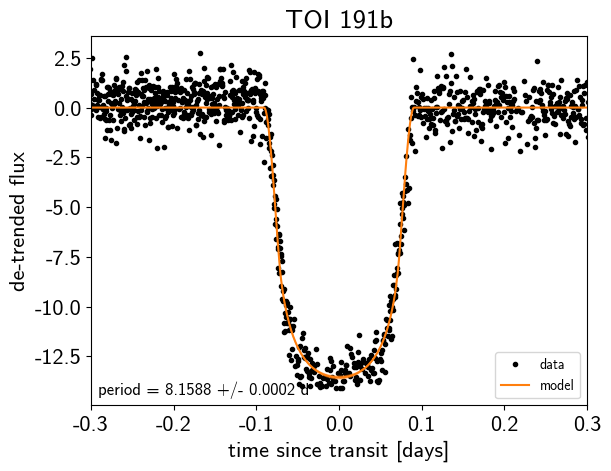

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

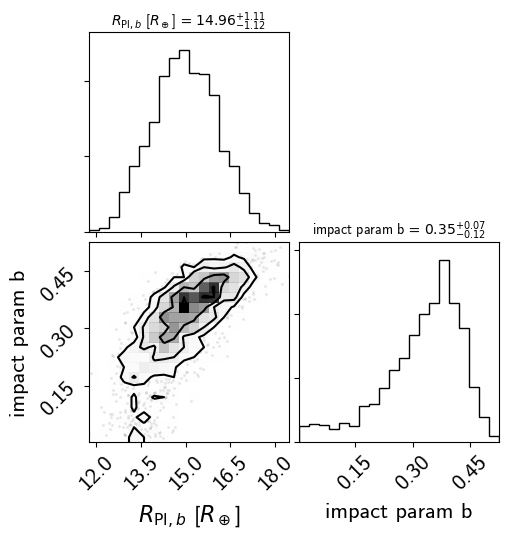

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

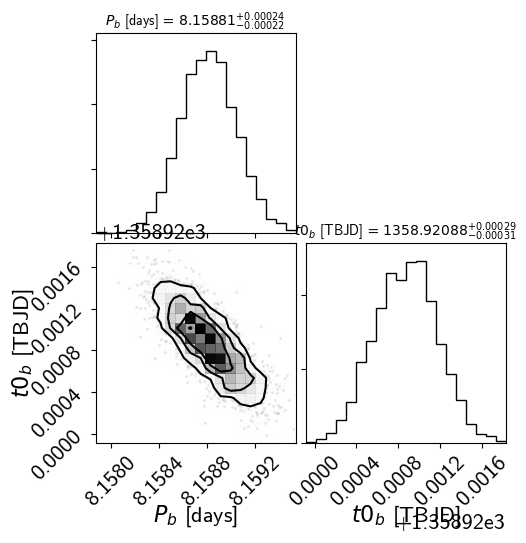

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

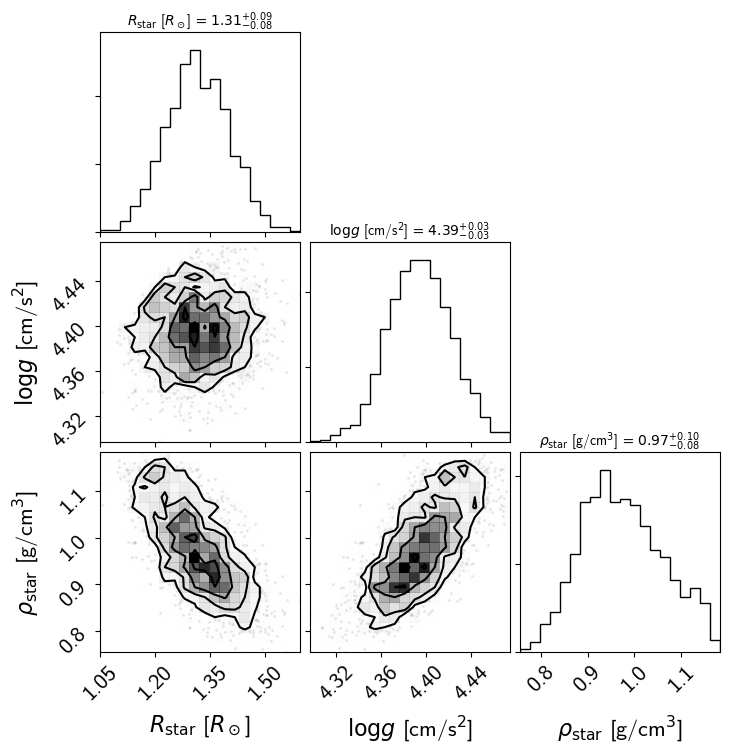

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3